# The link to the original notebook

> https://www.kaggle.com/lisphilar/covid-19-data-with-sir-model

# Introduction
Using a mathematical epidemic model, this notebook will predict the number of cases infected with COVID-19 (Novel Corona Virus 2019, 2019-nCOV, SARS-COV-2 virus caused disease). The goal of this notebook is to find the actions which enables to settle the situation more quickly.

 * Preparation
 * Grouping by growth factor
 * Trend analysis
 * SIR to SIR-F
 * SIR-F with exposed/waiting cases
 * Factors of model parameters
 * Scenario in Italy
 * Scenario in Japan  (**Under construction**)
 * Remarks

Note: "Infected" means the currently infected and confirmed cases. This can be calculated  as "Confirmed" - "Deaths" - "Recovered"

In [1]:
from datetime import datetime
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)

## Major update
 * 13Feb2020-19Mar2020: (Shown in "Remark" section.)

 * 29Mar2020: Grouping of countries by growth factor
 * 29Mar2020: Update "Scenario in Italy" section to include confirmed national lockdown effect
 * 05Apr2020: Update simulation() fucntion, dense_ouput=False
 * 05Apr2020: Create Scenario() class
 * 06Apr2020: Update Scenario() class to reduce running time
 
 <!--* 10Mar2020: In Estimator.objective(), apply adjusted Exponential Moving Average (span=7days) on the training data-->
 
 <!--* 08Mar2020: ODE solver method was changed from RK45 to Radau (Implicit Runge-Kutta method of the Radau IIA family of order 5) because max value of $\tau$ is 1440[min] and the number of iterations tends to small. The numerical simulation system seems stiff equation. Please refer to [scipy.integrate.solve_ivp guide](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html).-->

## Acknowledgement
### Dataset in kaggle
* The number of cases: [Novel Corona Virus 2019 Dataset](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset)
* Total population: [covid19-global-forecasting-locations-population](https://www.kaggle.com/dgrechka/covid19-global-forecasting-locations-population/metadata)
* Population pyramid: [Population Pyramid 2019](https://www.kaggle.com/hotessy/population-pyramid-2019)
* Mesaures in each country: [COVID-19 containment and mitigation measures](https://www.kaggle.com/paultimothymooney/covid19-containment-and-mitigation-measures)
* Measures in Italy: [COVID-19 Prevention in Italy](https://www.kaggle.com/marcoferrante/covid19-prevention-in-italy)
* The number of cases in Japan: [COVID-19 dataset in Japan](https://www.kaggle.com/lisphilar/covid19-dataset-in-japan)

### Data provided by kagglers as a comment on this notebook
* The number of days persons of each age group usually go out provided by @marcoferrante

### External resource
* Population pyramid: [PopulationPyramid.net](https://www.populationpyramid.net/) licenced under [Creative Commons license CC BY 3.0](https://creativecommons.org/licenses/by/3.0/igo/)

# Preparation

## Package

In [2]:
from collections import defaultdict
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import os
from pprint import pprint
import warnings
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import pystan.misc # in model.fit(): AttributeError: module 'pystan' has no attribute 'misc'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import numpy as np
import optuna
optuna.logging.disable_default_handler()
import pandas as pd
import dask.dataframe as dd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
from scipy.integrate import solve_ivp

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [4]:
np.random.seed(2019)
os.environ["PYTHONHASHSEED"] = "2019"

In [5]:
plt.style.use("seaborn-ticks")
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 11.0
plt.rcParams["figure.figsize"] = (9, 6)

In [6]:
pd.set_option("display.max_colwidth", 1000)

## Total population

In [7]:
population_raw = pd.read_csv(
    "../input/covid19-global-forecasting-locations-population/locations_population.csv"
)

In [8]:
population_raw.head()

,Province.State,Country.Region,Population,Provenance
0,NaN,Afghanistan,35530000,NaN
1,NaN,Albania,2877000,NaN
2,NaN,Algeria,41320000,NaN
3,NaN,Andorra,78000,NaN
4,NaN,Antigua and Barbuda,102012,NaN


In [9]:
pd.DataFrame(population_raw.isnull().sum()).T

,Province.State,Country.Region,Population,Provenance
0,196,0,0,314


In [10]:
df = population_raw.copy()
df = df.rename({"Province.State": "Province", "Country.Region": "Country"}, axis=1)
cols = ["Country", "Province", "Population"]
df = df.loc[:, cols].fillna("-")
df.loc[df["Country"] == df["Province"], "Province"] = "-"
# Add total records
_total_df = df.loc[df["Province"] != "-", :].groupby("Country").sum()
_total_df = _total_df.reset_index().assign(Province="-")
df = pd.concat([df, _total_df], axis=0, sort=True)
df = df.drop_duplicates(subset=["Country", "Province"], keep="first")
# Global
global_value = df.loc[df["Province"] == "-", "Population"].sum()
df = df.append(pd.Series(["Global", "-", global_value], index=cols), ignore_index=True)
# Sorting
df = df.sort_values("Population", ascending=False).reset_index(drop=True)
df = df.loc[:, cols]
population_df = df.copy()
population_df.head()

,Country,Province,Population
0,Global,-,7454412229
1,China,-,1376807262
2,India,-,1339000000
3,US,-,327200000
4,Indonesia,-,264000000


In [11]:
df = population_df.loc[population_df["Province"] == "-", :]
population_dict = df.set_index("Country").to_dict()["Population"]
population_dict

{'Global': 7454412229,
 'China': 1376807262,
 'India': 1339000000,
 'US': 327200000,
 'Indonesia': 264000000,
 'Brazil': 209300000,
 'Pakistan': 197000000,
 'Nigeria': 190900000,
 'Bangladesh': 164700000,
 'Russia': 144500000,
 'Mexico': 129200000,
 'Japan': 126800000,
 'Ethiopia': 105000000,
 'Philippines': 104900000,
 'Egypt': 97550000,
 'Vietnam': 95540000,
 'Germany': 82790000,
 'Republic of the Congo': 81340000,
 'Iran': 81160000,
 'Turkey': 80810000,
 'Thailand': 69040000,
 'United Kingdom': 66440000,
 'France': 64266012,
 'Italy': 60480000,
 'Tanzania': 57310000,
 'South Africa': 56720000,
 'Burma': 54319034,
 'Korea, South': 51470000,
 'Kenya': 49700000,
 'Colombia': 49070000,
 'Spain': 46660000,
 'Argentina': 44270000,
 'Uganda': 42860000,
 'Ukraine': 42220000,
 'Algeria': 41320000,
 'Sudan': 40530000,
 'Iraq': 38270000,
 'Poland': 37980000,
 'Canada': 37855939,
 'Morocco': 35740000,
 'Afghanistan': 35530000,
 'Saudi Arabia': 32940000,
 'Uzbekistan': 32390000,
 'Peru': 3217000

## Population pyramid

In [12]:
pyramid_csv_list = list()
for dirname, _, filenames in os.walk("../input/population-pyramid-2019/"):
    for filename in filenames:
        name = os.path.join(dirname, filename)
        df = pd.read_csv(name)
        df["Country"], df["Year"], _ = filename.replace(".", "-").split("-")
        pyramid_csv_list.append(df)
pyramid_raw = pd.concat(pyramid_csv_list, sort=True)
pyramid_raw.head()

,Age,Country,F,M,Year
0,0-4,Canada,965981,1013876,2019
1,5-9,Canada,967470,1012761,2019
2,10-14,Canada,961187,1006817,2019
3,15-19,Canada,978597,1027473,2019
4,20-24,Canada,1176141,1231211,2019


In [13]:
pyramid_raw["Country"].unique()

array(['Canada', 'China', 'France', 'Germany', 'India', 'Iran', 'Italy',
       'Japan', 'Spain', 'United Kingdom', 'United States of America'],
      dtype=object)

In [14]:
df = pyramid_raw.copy()
df["Country"] = df["Country"].replace(
    {
        "United States of America": "US",
        "United Kingdom": "UK",
    }
)
# Global (WORLD)
_male = [
    349432556, 342927576, 331497486, 316642222, 308286775, 306059387, 309236984,
    276447037, 249389688, 241232876, 222609691, 192215395, 157180267, 128939392,
    87185982, 54754941, 33648953, 15756942, 5327866, 1077791, 124144
]
_female = [
    328509234, 321511867, 309769906, 295553758, 289100903, 288632766, 296293748,
    268371754, 244399176, 238133281, 223162982, 195633743, 164961323, 140704320,
    101491347, 69026831, 48281201, 26429329, 11352182, 3055845, 449279
]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Global",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Sweden
_male = [
    307116,
    304759,
    296771,
    270840,
    291723,
    376952,
    343311,
    315086,
    312017,
    336452,
    342117,
    306949,
    279609,
    265511,
    273061,
    195029,
    113166,
    61775,
    26170,
    6768,
    415
]
_female = [
    290553,
    288817,
    280944,
    257677,
    274760,
    361526,
    330153,
    300752,
    301288,
    327453,
    331458,
    300084,
    280009,
    272149,
    286879,
    212480,
    143654,
    97633,
    52624,
    18130,
    1771
]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Sweden",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Philippines
_male = [
    5534962,
    5820604,
    5538414,
    5383822,
    5149849,
    4710777,
    4061897,
    3581091,
    3237426,
    2832825,
    2482953,
    2015857,
    1556935,
    1082875,
    668107,
    364200,
    199400,
    73508,
    17327,
    3035,
    208
]
_female = [
    5240508,
    5541514,
    5273495,
    5029137,
    4896316,
    4589506,
    3982681,
    3544279,
    3191565,
    2825286,
    2521463,
    2112380,
    1714689,
    1285782,
    895866,
    567282,
    360751,
    155294,
    57969,
    13376,
    1411
]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Philippines",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Arrange
df["Population"] = df["F"] + df["M"]
df = df.pivot_table(
    index="Age", columns=["Country"], values="Population", aggfunc="last"
)
df = df.astype(np.int64).reset_index().rename({"Age": "Age_bin"}, axis=1)
series = df["Age_bin"].str.replace("+", "-122")
df[["Age_first", "Age_last"]] = series.str.split("-", expand=True).astype(np.int64)
df = df.drop("Age_bin", axis=1)
series = df["Age_last"]
df = df.apply(lambda x: x[:-2] / (x[-1] - x[-2] + 1), axis=1)
df["Age"] = series
df = pd.merge(df, pd.DataFrame({"Age": np.arange(0, 123, 1)}), on="Age", how="right", sort=True)
df = df.fillna(method="bfill").astype(np.int64)
df = df.set_index("Age")
pyramid_df = df.copy()
pyramid_df

,Canada,China,France,Germany,Global,India,Iran,Italy,Japan,Philippines,Spain,Sweden,UK,US
Age,,,,,,,,,,,,,,
0,395971,17008206,733844,797488,135588358,23356364,1516560,476509,981106,2155094,403236,119533,790209,3920819
1,395971,17008206,733844,797488,135588358,23356364,1516560,476509,981106,2155094,403236,119533,790209,3920819
2,395971,17008206,733844,797488,135588358,23356364,1516560,476509,981106,2155094,403236,119533,790209,3920819
3,395971,17008206,733844,797488,135588358,23356364,1516560,476509,981106,2155094,403236,119533,790209,3920819
4,395971,17008206,733844,797488,135588358,23356364,1516560,476509,981106,2155094,403236,119533,790209,3920819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,352,2949,808,769,24931,1947,21,694,3182,70,535,95,667,3910
119,352,2949,808,769,24931,1947,21,694,3182,70,535,95,667,3910
120,352,2949,808,769,24931,1947,21,694,3182,70,535,95,667,3910


## The number of days go out (template data)
**As a comment of this notebook, @marcoferrante estimated the number of days persons of each age group usually go out. Thank you for your kind cooperation!!**

In [15]:
# @marcoferrante estimation
_period_of_life_list = [
    "nursery", "nursery school", "elementary school", "middle school",
    "high school", "university/work", "work", "work", "work", "work",
    "retired", "retired", "retired"
]
df = pd.DataFrame(
    {
        "Age_first": [0, 3, 6, 11, 14, 19, 26, 36, 46, 56, 66, 76, 86],
        "Age_last": [2, 5, 10, 13, 18, 25, 35, 45, 55, 65, 75, 85, 95],
        "Period_of_life": _period_of_life_list,
        "Days": [3, 5, 6, 6, 7, 7, 6, 5, 5, 5, 4, 3, 2]
    }
)
# Adjustment by author
df["Types"] = df["Period_of_life"].replace(
    {
        "nursery": "school",
        "nursery school": "school",
        "elementary school": "school",
        "middle school": "school",
        "high school": "school",
        "university/work": "school/work"
    }
)
df["School"] = df[["Types", "Days"]].apply(lambda x: x[1] if "school" in x[0] else 0, axis=1)
df["Office"] = df[["Types", "Days"]].apply(lambda x: x[1] if "work" in x[0] else 0, axis=1)
df["Others"] = df["Days"] - df[["School", "Office"]].sum(axis=1)
df.loc[df["Others"] < 0, "Others"] = 0
df.loc[df.index[1:5], "School"] -= 1
df.loc[df.index[1:5], "Others"] += 1
df.loc[df.index[5], ["School", "Office", "Others"]] = [3, 3, 1]
df[["School", "Office", "Others"]] = df[["Days", "School", "Office", "Others"]].apply(
    lambda x: x[1:] / sum(x[1:]) * x[0], axis=1
).astype(np.int64)
df.loc[df.index[6:10], "Others"] += 1
df = df.drop(["Days", "Types"], axis=1)
# Show dataset
_out_df = df.copy()
_out_df

,Age_first,Age_last,Period_of_life,School,Office,Others
0,0,2,nursery,3,0,0
1,3,5,nursery school,4,0,1
2,6,10,elementary school,5,0,1
3,11,13,middle school,5,0,1
4,14,18,high school,6,0,1
5,19,25,university/work,3,3,1
6,26,35,work,0,6,1
7,36,45,work,0,5,1
8,46,55,work,0,5,1
9,56,65,work,0,5,1


For each country, population pyramid data will be combined to the table. The columns with countriy names are the portion of the total population.

In [16]:
df = pyramid_df.cumsum()
countries = df.columns[:]
df = pd.merge(_out_df, df, left_on="Age_last", right_on="Age", how="left")
_first = df.loc[df.index[0], countries]
df[countries] = df[countries].diff()
df.loc[df.index[0], countries] = _first
df[countries] = df[countries].apply(lambda x: x / x.sum(), axis=0)
out_df = df.copy()
out_df

,Age_first,Age_last,Period_of_life,School,Office,Others,Canada,China,France,Germany,Global,India,Iran,Italy,Japan,Philippines,Spain,Sweden,UK,US
0,0,2,nursery,3,0,0,0.031811,0.035600,0.033901,0.028711,0.052210,0.051289,0.054879,0.023674,0.023292,0.059807,0.025943,0.035809,0.035174,0.035813
1,3,5,nursery school,4,0,1,0.031813,0.035809,0.034727,0.028115,0.051864,0.051752,0.052977,0.024795,0.024166,0.060893,0.027265,0.035727,0.035658,0.036229
2,6,10,elementary school,5,0,1,0.052963,0.059984,0.060787,0.045016,0.084689,0.088830,0.080195,0.045552,0.043395,0.104088,0.050480,0.058956,0.060363,0.062293
3,11,13,middle school,5,0,1,0.031621,0.035035,0.036844,0.027347,0.049386,0.055770,0.043894,0.028506,0.026526,0.060010,0.031812,0.034614,0.034583,0.038632
4,14,18,high school,6,0,1,0.053517,0.057906,0.059948,0.048961,0.079324,0.092191,0.067379,0.047546,0.045251,0.097064,0.048522,0.053759,0.055262,0.064638
5,19,25,university/work,3,3,1,0.089688,0.087912,0.080317,0.076269,0.107659,0.124634,0.099528,0.068986,0.066696,0.129404,0.068295,0.081871,0.085452,0.095708
6,26,35,work,0,6,1,0.141335,0.160417,0.119402,0.124868,0.152774,0.164456,0.192333,0.110560,0.106875,0.156425,0.113973,0.138543,0.136443,0.139912
7,36,45,work,0,5,1,0.133597,0.140662,0.124751,0.123987,0.131630,0.135250,0.163720,0.137011,0.134815,0.122671,0.162583,0.123699,0.129938,0.125441
8,46,55,work,0,5,1,0.132237,0.166102,0.134609,0.150438,0.116396,0.103354,0.110998,0.161104,0.142129,0.095804,0.158071,0.132422,0.134289,0.125788
9,56,65,work,0,5,1,0.137679,0.116123,0.124850,0.143657,0.088096,0.074217,0.075731,0.135972,0.123395,0.065197,0.128555,0.115113,0.119465,0.125640


In [17]:
def go_out(country, out_df=out_df):
    """
    Return the estimated number of days people usually go out.
    @country <str>: coutry name
    @out_df <pd.DataFrame>: template dataframe
    """
    df = out_df.copy()
    try:
        series = df[country]
    except KeyError:
        raise KeyError(f"Population pyramid data of {country} is not defined!")
    df = df.iloc[:, :6]
    df["Portion"] = series
    return df

In [18]:
go_out("Global")

,Age_first,Age_last,Period_of_life,School,Office,Others,Portion
0,0,2,nursery,3,0,0,0.052210
1,3,5,nursery school,4,0,1,0.051864
2,6,10,elementary school,5,0,1,0.084689
3,11,13,middle school,5,0,1,0.049386
4,14,18,high school,6,0,1,0.079324
5,19,25,university/work,3,3,1,0.107659
6,26,35,work,0,6,1,0.152774
7,36,45,work,0,5,1,0.131630
8,46,55,work,0,5,1,0.116396
9,56,65,work,0,5,1,0.088096


## Functions
Here, we define the functions to use repeatedly in this notebook.

### Plotting

In [19]:
def line_plot(df, title, ylabel="Cases", h=None, v=None,
              xlim=(None, None), ylim=(0, None), math_scale=True, y_logscale=False, y_integer=False):
    """
    Show chlonological change of the data.
    """
    ax = df.plot()
    if math_scale:
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style="sci",  axis="y",scilimits=(0, 0))
    if y_logscale:
        ax.set_yscale("log")
    if y_integer:
        fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
        fmt.set_scientific(False)
        ax.yaxis.set_major_formatter(fmt)
    ax.set_title(title)
    ax.set_xlabel(None)
    ax.set_ylabel(ylabel)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
    if h is not None:
        ax.axhline(y=h, color="black", linestyle="--")
    if v is not None:
        if not isinstance(v, list):
            v = [v]
        for value in v:
            ax.axvline(x=value, color="black", linestyle="--")
    plt.tight_layout()
    plt.show()

### Trend analysis

In [20]:
def select_area(ncov_df, group="Date", places=None, areas=None, excluded_places=None,
                start_date=None, end_date=None, date_format="%d%b%Y"):
    """
    Select the records of the palces.
    @ncov_df <pd.DataFrame>: the clean data
    @group <str or None>: group-by the group, or not perform (None)
    @area or @places:
        if ncov_df has Country and Province column,
            @places <list[tuple(<str/None>, <str/None>)]: the list of places
                - if the list is None, all data will be used
                - (str, str): both of country and province are specified
                - (str, None): only country is specified
                - (None, str) or (None, None): Error
        if ncov_df has Area column,
            @areas <list[str]>: the list of area names
                - if the list is None, all data will be used
                - eg. Japan
                - eg. US/California
    @excluded_places <list[tuple(<str/None>, <str/None>)]: the list of excluded places
        - if the list is None, all data in the "places" will be used
        - (str, str): both of country and province are specified
        - (str, None): only country is specified
        - (None, str) or (None, None): Error
    @start_date <str>: the start date or None
    @end_date <str>: the start date or None
    @date_format <str>: format of @start_date and @end_date
    @return <pd.DataFrame>: index and columns are as same as @ncov_df
    """
    # Select the target records
    df = ncov_df.copy()
    if (places is not None) or (excluded_places is not None):
        c_series = df["Country"]
        p_series = df["Province"]
        if places is not None:
            df = pd.DataFrame(columns=ncov_df.columns)
            for (c, p) in places:
                if c is None:
                    raise Exception("places: Country must be specified!")
                if p is None:
                    new_df = ncov_df.loc[c_series == c, :]
                else:
                    new_df = ncov_df.loc[(c_series == c) & (p_series == p), :]
                df = pd.concat([df, new_df], axis=0)
        if excluded_places is not None:
            for (c, p) in excluded_places:
                if c is None:
                    raise Exception("excluded_places: Country must be specified!")
                if p is None:
                    df = df.loc[c_series != c, :]
                else:
                    c_df = df.loc[(c_series == c) & (p_series != p), :]
                    other_df = df.loc[c_series != c, :]
                    df = pd.concat([c_df, other_df], axis=0)
    if areas is not None:
        df = df.loc[df["Area"].isin(areas), :]
    if group is not None:
        df = df.groupby(group).sum().reset_index()
    # Range of date
    if start_date is not None:
        df = df.loc[df["Date"] >= datetime.strptime(start_date, date_format), :]
    if end_date is not None:
        df = df.loc[df["Date"] <= datetime.strptime(end_date, date_format), :]
    # Only use the records with Confirmed > 0
    try:
        df = df.loc[df["Confirmed"] > 0, :]
    except KeyError:
        pass
    # Aleart empty
    if df.empty:
        raise Exception("The output dataframe is empty!")
    return df

In [21]:
def show_trend(ncov_df, name=None, variable="Confirmed", n_changepoints=2, **kwargs):
    """
    Show trend of log10(@variable) using fbprophet package.
    @ncov_df <pd.DataFrame>: the clean data
    @variable <str>: variable name to analyse
        - if Confirmed, use Infected + Recovered + Deaths
    @n_changepoints <int>: max number of change points
    @kwargs: keword arguments of select_area()
    """
    # Data arrangement
    df = select_area(ncov_df, **kwargs)
    df = df.loc[:, ["Date", variable]]
    df.columns = ["ds", "y"]
    # Log10(x)
    warnings.resetwarnings()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df["y"] = np.log10(df["y"]).replace([np.inf, -np.inf], 0)
    # fbprophet
    model = Prophet(growth="linear", daily_seasonality=False, n_changepoints=n_changepoints)
    model.fit(df)
    future = model.make_future_dataframe(periods=0)
    forecast = model.predict(future)
    # Create figure
    fig = model.plot(forecast)
    _ = add_changepoints_to_plot(fig.gca(), model, forecast)
    if name is None:
        try:
            name = f"{kwargs['places'][0][0]}: "
        except Exception:
            name = str()
    else:
        name = f"{name}: "
    plt.title(f"{name}log10({variable}) over time and chainge points")
    plt.ylabel(f"log10(the number of cases)")
    plt.xlabel("")

### Dataset arrangement

In [22]:
def create_target_df(ncov_df, total_population,
                     confirmed="Confirmed", recovered="Recovered", fatal="Deaths", **kwargs):
    """
    Select the records of the places, calculate the number of susceptible people,
     and calculate the elapsed time [day] from the start date of the target dataframe.
    @ncov_df <pd.DataFrame>: the clean data
    @total_population <int>: total population in the places
    column names in @ncov_df:
        @confirmed <str>: column name of the number of confirmed cases
        @recovered <str>: column name of the number of recovered cases
        @fatal <str>: column name of the number of fatal cases
    @kwargs: keword arguments of select_area()
    @return <tuple(2 objects)>:
        - 1. first_date <pd.Timestamp>: the first date of the selected records
        - 2. target_df <pd.DataFrame>:
            - column T: elapsed time [min] from the start date of the dataset
            - column Susceptible: the number of patients who are in the palces but not infected/recovered/died
            - column Infected: the number of infected cases
            - column Recovered: the number of recovered cases
            - column Deaths: the number of death cases
    """
    # Select the target records
    df = select_area(ncov_df, **kwargs)
    first_date = df.loc[df.index[0], "Date"]
    # column T
    df["T"] = ((df["Date"] - first_date).dt.total_seconds() / 60).astype(int)
    # coluns except T
    cols = [confirmed, recovered, fatal]
    if not set(cols).issubset(set(df.columns)):
        raise KeyError(f"ncov_df must have {', '.join(cols)} column!")
    df["Susceptible"] = total_population - df[confirmed]
    df["Infected"] = df[confirmed] - df[recovered] - df[fatal]
    df["Recovered"] = df[recovered]
    df["Fatal"] = df.loc[:, fatal]
    response_variables = ["Susceptible", "Infected", "Recovered", "Fatal"]
    # Return
    target_df = df.loc[:, ["T", *response_variables]]
    return (first_date, target_df)

### Numerical simulation
We will perform numerical analysis to solve the ODE using scipy.integrate.solve_ivp function.

In [23]:
def simulation(model, initials, step_n, **params):
    """
    Solve ODE of the model.
    @model <ModelBase>: the model
    @initials <tuple[float]>: the initial values
    @step_n <int>: the number of steps
    @params: the paramerters of the model
    """
    tstart, dt, tend = 0, 1, step_n
    sol = solve_ivp(
        fun=model(**params),
        t_span=[tstart, tend],
        y0=np.array(initials, dtype=np.float64),
        t_eval=np.arange(tstart, tend + dt, dt),
        dense_output=False  # True
    )
    t_df = pd.Series(data=sol["t"], name="t")
    y_df = pd.DataFrame(data=sol["y"].T.copy(), columns=model.VARIABLES)
    sim_df = pd.concat([t_df, y_df], axis=1)
    return sim_df

### Description of math model

In [24]:
class ModelBase(object):
    NAME = "Model"
    VARIABLES = ["x"]
    PRIORITIES = np.array([1])
    QUANTILE_RANGE = [0.3, 0.7]
    MONOTONIC = ["x"]

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        """
        Define parameters without tau. This function should be overwritten.
        @train_df_divided <pd.DataFrame>:
            - column: t and non-dimensional variables
        @q_range <list[float, float]>: quantile rage of the parameters calculated by the data
        @return <dict[name]=(min, max):
            @min <float>: min value
            @max <float>: max value
        """
        param_dict = dict()
        return param_dict

    @staticmethod
    def calc_variables(df):
        """
        Calculate the variables of the model.
        This function should be overwritten.
        @df <pd.DataFrame>
        @return <pd.DataFrame>
        """
        return df

    @staticmethod
    def calc_variables_reverse(df):
        """
        Calculate measurable variables using the variables of the model.
        This function should be overwritten.
        @df <pd.DataFrame>
        @return <pd.DataFrame>
        """
        return df

    @classmethod
    def create_dataset(cls, ncov_df, total_population, **kwargs):
        """
        Create dataset with the model-specific varibles.
        The variables will be divided by total population.
        The column names (not include T) will be lower letters.
        **kwargs: See the function named create_target_df()
        @return <tuple(objects)>:
            - start_date <pd.Timestamp>
            - initials <tuple(float)>: the initial values
            - Tend <int>: the last value of T
            - df <pd.DataFrame>: the dataset
        """
        start_date, target_df = create_target_df(ncov_df, total_population, **kwargs)
        df = cls.calc_variables(target_df).set_index("T") / total_population
        df.columns = [n.lower() for n in df.columns]
        initials = df.iloc[0, :].values
        df = df.reset_index()
        Tend = df.iloc[-1, 0]
        return (start_date, initials, Tend, df)

    def calc_r0(self):
        """
        Calculate R0. This function should be overwritten.
        """
        return None

    def calc_days_dict(self, tau):
        """
        Calculate 1/beta [day] etc.
        This function should be overwritten.
        @param tau <int>: tau value [hour]
        """
        return dict()

#### SIR model

In [25]:
class SIR(ModelBase):
    NAME = "SIR"
    VARIABLES = ["x", "y", "z"]
    PRIORITIES = np.array([1, 1, 1])
    MONOTONIC = ["z"]

    def __init__(self, rho, sigma):
        super().__init__()
        self.rho = rho
        self.sigma = sigma

    def __call__(self, t, X):
        # x, y, z = [X[i] for i in range(len(self.VARIABLES))]
        # dxdt = - self.rho * x * y
        # dydt = self.rho * x * y - self.sigma * y
        # dzdt = self.sigma * y
        dxdt = - self.rho * X[0] * X[1]
        dydt = self.rho * X[0] * X[1] - self.sigma * X[1]
        dzdt = self.sigma * X[1]
        return np.array([dxdt, dydt, dzdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        if train_df_divided is not None:
            df = train_df_divided.copy()
            # rho = - (dx/dt) / x / y
            rho_series = 0 - df["x"].diff() / df["t"].diff() / df["x"] / df["y"]
            param_dict["rho"] = rho_series.quantile(q_range)
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = sigma_series.quantile(q_range)
            return param_dict
        param_dict["rho"] = (0, 1)
        param_dict["sigma"] = (0, 1)
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X"] = df["Susceptible"]
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"] + df["Fatal"]
        return df.loc[:, ["T", "X", "Y", "Z"]]

    @staticmethod
    def calc_variables_reverse(df):
        df["Susceptible"] = df["X"]
        df["Infected"] = df["Y"]
        df["Recovered/Deaths"] = df["Z"]
        return df

    def calc_r0(self):
        if self.sigma == 0:
            return np.nan
        r0 = self.rho / self.sigma
        return round(r0, 2)

    def calc_days_dict(self, tau):
        _dict = dict()
        _dict["1/beta [day]"] = int(tau / 24 / 60 / self.rho)
        _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

#### SIR-D model

In [26]:
class SIRD(ModelBase):
    NAME = "SIR-D"
    VARIABLES = ["x", "y", "z", "w"]
    PRIORITIES = np.array([1, 10, 10, 2])
    MONOTONIC = ["z", "w"]

    def __init__(self, kappa, rho, sigma):
        super().__init__()
        self.kappa = kappa
        self.rho = rho
        self.sigma = sigma

    def __call__(self, t, X):
        # x, y, z, w = [X[i] for i in range(len(self.VARIABLES))]
        # dxdt = - self.rho * x * y
        # dydt = self.rho * x * y - (self.sigma + self.kappa) * y
        # dzdt = self.sigma * y
        # dwdt = self.kappa * y
        dxdt = - self.rho * X[0] * X[1]
        dydt = self.rho * X[0] * X[1] - (self.sigma + self.kappa) * X[1]
        dzdt = self.sigma * X[1]
        dwdt = self.kappa * X[1]
        return np.array([dxdt, dydt, dzdt, dwdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        if train_df_divided is not None:
            df = train_df_divided.copy()
            # kappa = (dw/dt) / y
            kappa_series = df["w"].diff() / df["t"].diff() / df["y"]
            param_dict["kappa"] = kappa_series.quantile(q_range)
            # rho = - (dx/dt) / x / y
            rho_series = 0 - df["x"].diff() / df["t"].diff() / df["x"] / df["y"]
            param_dict["rho"] = rho_series.quantile(q_range)
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = sigma_series.quantile(q_range)
            return param_dict
        param_dict["kappa"] = (0, 1)
        param_dict["rho"] = (0, 1)
        param_dict["sigma"] = (0, 1)
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X"] = df["Susceptible"]
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"]
        df["W"] = df["Fatal"]
        return df.loc[:, ["T", "X", "Y", "Z", "W"]]

    @staticmethod
    def calc_variables_reverse(df):
        df["Susceptible"] = df["X"]
        df["Infected"] = df["Y"]
        df["Recovered"] = df["Z"]
        df["Deaths"] = df["W"]
        return df

    def calc_r0(self):
        try:
            r0 = self.rho / (self.sigma + self.kappa)
        except ZeroDivisionError:
            return np.nan
        return round(r0, 2)


    def calc_days_dict(self, tau):
        _dict = dict()
        if self.kappa == 0:
            _dict["1/alpha2 [day]"] = 0
        else:
            _dict["1/alpha2 [day]"] = int(tau / 24 / 60 / self.kappa)
        _dict["1/beta [day]"] = int(tau / 24 / 60 / self.rho)
        if self.sigma == 0:
            _dict["1/gamma [day]"] = 0
        else:
            _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

#### SIR-F model

In [27]:
class SIRF(ModelBase):
    NAME = "SIR-F"
    VARIABLES = ["x", "y", "z", "w"]
    PRIORITIES = np.array([1, 10, 10, 2])
    MONOTONIC = ["z", "w"]

    def __init__(self, theta, kappa, rho, sigma):
        super().__init__()
        self.theta = theta
        self.kappa = kappa
        self.rho = rho
        self.sigma = sigma

    def __call__(self, t, X):
        # x, y, z, w = [X[i] for i in range(len(self.VARIABLES))]
        # dxdt = - self.rho * x * y
        # dydt = self.rho * (1 - self.theta) * x * y - (self.sigma + self.kappa) * y
        # dzdt = self.sigma * y
        # dwdt = self.rho * self.theta * x * y + self.kappa * y
        dxdt = - self.rho * X[0] * X[1]
        dydt = self.rho * (1 - self.theta) * X[0] * X[1] - (self.sigma + self.kappa) * X[1]
        dzdt = self.sigma * X[1]
        dwdt = self.rho * self.theta * X[0] * X[1] + self.kappa * X[1]
        return np.array([dxdt, dydt, dzdt, dwdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        param_dict["theta"] = (0, 1)
        param_dict["kappa"] = (0, 1)
        if train_df_divided is not None:
            df = train_df_divided.copy()
            # rho = - (dx/dt) / x / y
            rho_series = 0 - df["x"].diff() / df["t"].diff() / df["x"] / df["y"]
            param_dict["rho"] = rho_series.quantile(q_range)
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = sigma_series.quantile(q_range)
            return param_dict
        param_dict["rho"] = (0, 1)
        param_dict["sigma"] = (0, 1)
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X"] = df["Susceptible"]
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"]
        df["W"] = df["Fatal"]
        return df.loc[:, ["T", "X", "Y", "Z", "W"]]

    @staticmethod
    def calc_variables_reverse(df):
        df["Susceptible"] = df["X"]
        df["Infected"] = df["Y"]
        df["Recovered"] = df["Z"]
        df["Fatal"] = df["W"]
        return df

    def calc_r0(self):
        try:
            r0 = self.rho * (1 - self.theta) / (self.sigma + self.kappa)
        except ZeroDivisionError:
            return np.nan
        return round(r0, 2)

    def calc_days_dict(self, tau):
        _dict = dict()
        _dict["alpha1 [-]"] = round(self.theta, 3)
        if self.kappa == 0:
            _dict["1/alpha2 [day]"] = 0
        else:
            _dict["1/alpha2 [day]"] = int(tau / 24 / 60 / self.kappa)
        _dict["1/beta [day]"] = int(tau / 24 / 60 / self.rho)
        if self.sigma == 0:
            _dict["1/gamma [day]"] = 0
        else:
            _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

#### SEWIR-F model

In [28]:
class SEWIRF(ModelBase):
    NAME = "SEWIR-F"
    VARIABLES = ["x1", "x2", "x3", "y", "z", "w"]
    PRIORITIES = np.array([0, 0, 0, 10, 10, 2])
    MONOTONIC = ["z", "w"]

    def __init__(self, theta, kappa, rho1, rho2, rho3, sigma):
        super().__init__()
        self.theta = theta
        self.kappa = kappa
        self.rho1 = rho1
        self.rho2 = rho2
        self.rho3 = rho3
        self.sigma = sigma

    def __call__(self, t, X):
        # x1, x2, x3, y, z, w = [X[i] for i in range(len(self.VARIABLES))]
        # dx1dt = - self.rho1 * x1 * (x3 + y)
        # dx2dt = self.rho1 * x1 * (x3 + y) - self.rho2 * x2
        # dx3dt = self.rho2 * x2 - self.rho3 * x3
        # dydt = self.rho3 * (1 - self.theta) * x3 - (self.sigma + self.kappa) * y
        # dzdt = self.sigma * y
        # dwdt = self.rho3 * self.theta * x3 + self.kappa * y
        dx1dt = - self.rho1 * X[0] * (X[2] + X[3])
        dx2dt = self.rho1 * X[0] * (X[2] + X[3]) - self.rho2 * X[1]
        dx3dt = self.rho2 * X[1] - self.rho3 * X[2]
        dydt = self.rho3 * (1 - self.theta) * X[2] - (self.sigma + self.kappa) * X[3]
        dzdt = self.sigma * X[3]
        dwdt = self.rho3 * self.theta * X[2] + self.kappa * X[3]
        return np.array([dx1dt, dx2dt, dx3dt, dydt, dzdt, dwdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        param_dict["theta"] = (0, 1)
        param_dict["kappa"] = (0, 1)
        param_dict["rho1"] = (0, 1)
        param_dict["rho2"] = (0, 1)
        param_dict["rho3"] = (0, 1)
        if train_df_divided is not None:
            df = train_df_divided.copy()
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = sigma_series.quantile(q_range)
            return param_dict
        param_dict["sigma"] = (0, 1)
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X1"] = df["Susceptible"]
        df["X2"] = 0
        df["X3"] = 0
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"]
        df["W"] = df["Fatal"]
        return df.loc[:, ["T", "X1", "X2", "X3", "Y", "Z", "W"]]

    @staticmethod
    def calc_variables_reverse(df):
        df["Susceptible"] = df["X1"]
        df["Infected"] = df["Y"]
        df["Recovered"] = df["Z"]
        df["Fatal"] = df["W"]
        df["Exposed"] = df["X2"]
        df["Waiting"] = df["X3"]
        return df

    def calc_r0(self):
        try:
            r0 = self.rho1 * (1 - self.theta) / (self.sigma + self.kappa)
        except ZeroDivisionError:
            return np.nan
        return round(r0, 2)

    def calc_days_dict(self, tau):
        _dict = dict()
        _dict["alpha1 [-]"] = round(self.theta, 3)
        if self.kappa == 0:
            _dict["1/alpha2 [day]"] = 0
        else:
            _dict["1/alpha2 [day]"] = int(tau / 24 / 60 / self.kappa)
        _dict["1/beta1 [day]"] = int(tau / 24 / 60 / self.rho1)
        _dict["1/beta2 [day]"] = int(tau / 24 / 60 / self.rho2)
        _dict["1/beta3 [day]"] = int(tau / 24 / 60 / self.rho3)
        if self.sigma == 0:
            _dict["1/gamma [day]"] = 0
        else:
            _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

#### SIR-FV model

In [29]:
class SIRFV(ModelBase):
    NAME = "SIR-FV"
    VARIABLES = ["x", "y", "z", "w"]
    PRIORITIES = np.array([1, 10, 10, 2])
    MONOTONIC = ["z", "w"]

    def __init__(self, theta, kappa, rho, sigma, omega=None, n=None, v_per_day=None):
        """
        (n and v_per_day) or omega must be applied.
        @n <float or int>: total population
        @v_par_day <float or int>: vacctinated persons per day
        """
        super().__init__()
        self.theta = theta
        self.kappa = kappa
        self.rho = rho
        self.sigma = sigma
        if omega is None:
            try:
                self.omega = float(v_per_day) / float(n)
            except TypeError:
                s = "Neither (n and va_per_day) nor omega must be applied!"
                raise TypeError(s)
        else:
            self.omega = float(omega)

    def __call__(self, t, X):
        # x, y, z, w = [X[i] for i in range(len(self.VARIABLES))]
        # x with vacctination
        dxdt = - self.rho * X[0] * X[1] - self.omega
        dxdt = 0 - X[0] if X[0] + dxdt < 0 else dxdt
        # y, z, w
        dydt = self.rho * (1 - self.theta) * X[0] * X[1] - (self.sigma + self.kappa) * X[1]
        dzdt = self.sigma * X[1]
        dwdt = self.rho * self.theta * X[0] * X[1] + self.kappa * X[1]
        return np.array([dxdt, dydt, dzdt, dwdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        param_dict["theta"] = (0, 1)
        param_dict["kappa"] = (0, 1)
        param_dict["omega"] = (0, 1)
        if train_df_divided is not None:
            df = train_df_divided.copy()
            # rho = - (dx/dt) / x / y
            rho_series = 0 - df["x"].diff() / df["t"].diff() / df["x"] / df["y"]
            param_dict["rho"] = rho_series.quantile(q_range)
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = sigma_series.quantile(q_range)
            return param_dict
        param_dict["rho"] = (0, 1)
        param_dict["sigma"] = (0, 1)
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X"] = df["Susceptible"]
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"]
        df["W"] = df["Fatal"]
        return df.loc[:, ["T", "X", "Y", "Z", "W"]]

    @staticmethod
    def calc_variables_reverse(df):
        df["Susceptible"] = df["X"]
        df["Infected"] = df["Y"]
        df["Recovered"] = df["Z"]
        df["Fatal"] = df["W"]
        df["Immuned"] = 1 - df[["X", "Y", "Z", "W"]].sum(axis=1)
        return df

    def calc_r0(self):
        try:
            r0 = self.rho * (1 - self.theta) / (self.sigma + self.kappa)
        except ZeroDivisionError:
            return np.nan
        return round(r0, 2)

    def calc_days_dict(self, tau):
        _dict = dict()
        _dict["alpha1 [-]"] = round(self.theta, 3)
        if self.kappa == 0:
            _dict["1/alpha2 [day]"] = 0
        else:
            _dict["1/alpha2 [day]"] = int(tau / 24 / 60 / self.kappa)
        _dict["1/beta [day]"] = int(tau / 24 / 60 / self.rho)
        if self.sigma == 0:
            _dict["1/gamma [day]"] = 0
        else:
            _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

### Parameter Estimation using Optuna

In [30]:
class Estimator(object):
    def __init__(self, model, ncov_df, total_population, name=None, places=None, areas=None,
                 excluded_places=None, start_date=None, end_date=None, date_format="%d%b%Y", **params):
        """
        Set training data.
        @model <ModelBase>: the model
        @name <str>: name of the area
        @params: fixed parameter of the model
        @the other params: See the function named create_target_df()
        """
        # Fixed parameters
        self.fixed_param_dict = params.copy()
        if None in params.values():
            self.fixed_param_dict = {
                k: v for (k, v) in params.items() if v is not None
            }
        # Register the dataset arranged for the model
        dataset = model.create_dataset(
            ncov_df, total_population, places=places, areas=areas,
            excluded_places=excluded_places,
            start_date=start_date, end_date=end_date, date_format=date_format
        )
        self.start_time, self.initials, self.Tend, self.train_df = dataset
        self.total_population = total_population
        self.name = name
        self.model = model
        self.param_dict = dict()
        self.study = None
        self.optimize_df = None

    def run(self, n_trials=500):
        """
        Try estimation (optimization of parameters and tau).
        @n_trials <int>: the number of trials
        """
        if self.study is None:
            self.study = optuna.create_study(direction="minimize")
        self.study.optimize(
            lambda x: self.objective(x),
            n_trials=n_trials,
            n_jobs=-1
        )
        param_dict = self.study.best_params.copy()
        param_dict.update(self.fixed_param_dict)
        param_dict["R0"] = self.calc_r0()
        param_dict["score"] = self.score()
        param_dict.update(self.calc_days_dict())
        self.param_dict = param_dict.copy()
        return param_dict

    def history_df(self):
        """
        Return the hsitory of optimization.
        @return <pd.DataFrame>
        """
        optimize_df = self.study.trials_dataframe()
        optimize_df["time[s]"] = optimize_df["datetime_complete"] - \
            optimize_df["datetime_start"]
        optimize_df["time[s]"] = optimize_df["time[s]"].dt.total_seconds()
        self.optimize_df = optimize_df.drop(
            ["datetime_complete", "datetime_start", "system_attrs__number"], axis=1)
        return self.optimize_df.sort_values("value", ascending=True)

    def history_graph(self):
        """
        Show the history of parameter search using pair-plot.
        """
        if self.optimize_df is None:
            self.history_df()
        df = self.optimize_df.copy()
        sns.pairplot(df.loc[:, df.columns.str.startswith(
            "params_")], diag_kind="kde", markers="+")
        plt.show()

    def objective(self, trial):
        # Time
        try:
            tau = self.fixed_param_dict["tau"]
        except KeyError:
            tau = trial.suggest_int("tau", 1, 1440)
        train_df_divided = self.train_df.copy()
        train_df_divided["t"] = (train_df_divided["T"] / tau).astype(np.int64)
        # Parameters
        param_dict = self.model.param_dict(train_df_divided)
        p_dict = {"tau": None}
        p_dict.update(
            {
                k: trial.suggest_uniform(k, *v)
                for (k, v) in param_dict.items()
            }
        )
        p_dict.update(self.fixed_param_dict)
        p_dict.pop("tau")
        # Simulation
        t_end = train_df_divided.loc[train_df_divided.index[-1], "t"]
        sim_df = simulation(self.model, self.initials, step_n=t_end, **p_dict)
        return self.error_f(train_df_divided, sim_df)

    def error_f(self, train_df_divided, sim_df):
        """
        We need to minimize the difference of the observed values and estimated values.
        This function calculate the difference of the estimated value and obsereved value.
        """
        n = self.total_population
        df = pd.merge(train_df_divided, sim_df, on="t", suffixes=("_observed", "_estimated"))
        diffs = [
            # Weighted Average: the recent data is more important
            p * np.average(
                abs(df[f"{v}_observed"] - df[f"{v}_estimated"]) / (df[f"{v}_observed"] * n + 1),
                weights=df["t"]
            )
            for (p, v) in zip(self.model.PRIORITIES, self.model.VARIABLES)
        ]
        return sum(diffs) * n

    def compare_df(self):
        """
        Show the taining data and simulated data in one dataframe.

        """
        est_dict = self.study.best_params.copy()
        est_dict.update(self.fixed_param_dict)
        tau = est_dict["tau"]
        est_dict.pop("tau")
        observed_df = self.train_df.drop("T", axis=1)
        observed_df["t"] = (self.train_df["T"] / tau).astype(int)
        t_end = observed_df.loc[observed_df.index[-1], "t"]
        sim_df = simulation(self.model, self.initials, step_n=t_end, **est_dict)
        df = pd.merge(observed_df, sim_df, on="t", suffixes=("_observed", "_estimated"))
        df = df.set_index("t")
        return df

    def compare_graph(self):
        """
        Compare obsereved and estimated values in graphs.
        """
        df = self.compare_df()
        use_variables = [
            v for (i, (p, v)) in enumerate(zip(self.model.PRIORITIES, self.model.VARIABLES))
            if p != 0 and i != 0
        ]
        val_len = len(use_variables) + 1
        fig, axes = plt.subplots(
            ncols=1, nrows=val_len, figsize=(9, 6 * val_len / 2))
        for (ax, v) in zip(axes.ravel()[1:], use_variables):
            df[[f"{v}_observed", f"{v}_estimated"]].plot.line(
                ax=ax, ylim=(0, None), sharex=True,
                title=f"{self.model.NAME}: Comparison of observed/estimated {v}(t)"
            )
            ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            ax.ticklabel_format(style="sci",  axis="y", scilimits=(0, 0))
            ax.legend(bbox_to_anchor=(1.02, 0),
                      loc="lower left", borderaxespad=0)
        for v in use_variables:
            df[f"{v}_diff"] = df[f"{v}_observed"] - df[f"{v}_estimated"]
            df[f"{v}_diff"].plot.line(
                ax=axes.ravel()[0], sharex=True,
                title=f"{self.model.NAME}: observed - estimated"
            )
        axes.ravel()[0].axhline(y=0, color="black", linestyle="--")
        axes.ravel()[0].yaxis.set_major_formatter(
            ScalarFormatter(useMathText=True))
        axes.ravel()[0].ticklabel_format(
            style="sci",  axis="y", scilimits=(0, 0))
        axes.ravel()[0].legend(bbox_to_anchor=(1.02, 0),
                               loc="lower left", borderaxespad=0)
        fig.tight_layout()
        fig.show()

    def calc_r0(self):
        """
        Calculate R0.
        """
        est_dict = self.study.best_params.copy()
        est_dict.update(self.fixed_param_dict)
        est_dict.pop("tau")
        model_instance = self.model(**est_dict)
        return model_instance.calc_r0()

    def calc_days_dict(self):
        """
        Calculate 1/beta etc.
        """
        est_dict = self.study.best_params.copy()
        est_dict.update(self.fixed_param_dict)
        tau = est_dict["tau"]
        est_dict.pop("tau")
        model_instance = self.model(**est_dict)
        return model_instance.calc_days_dict(tau)

    def predict_df(self, step_n):
        """
        Predict the values in the future.
        @step_n <int>: the number of steps
        @return <pd.DataFrame>: predicted data for measurable variables.
        """
        est_dict = self.study.best_params.copy()
        est_dict.update(self.fixed_param_dict)
        tau = est_dict["tau"]
        est_dict.pop("tau")
        df = simulation(self.model, self.initials, step_n=step_n, **est_dict)
        df["Time"] = (
            df["t"] * tau).apply(lambda x: timedelta(minutes=x)) + self.start_time
        df = df.set_index("Time").drop("t", axis=1)
        df = (df * self.total_population).astype(np.int64)
        upper_cols = [n.upper() for n in df.columns]
        df.columns = upper_cols
        df = self.model.calc_variables_reverse(df).drop(upper_cols, axis=1)
        return df

    def predict_graph(self, step_n, name=None, excluded_cols=None):
        """
        Predict the values in the future and create a figure.
        @step_n <int>: the number of steps
        @name <str>: name of the area
        @excluded_cols <list[str]>: the excluded columns in the figure
        """
        if self.name is not None:
            name = self.name
        else:
            name = str() if name is None else name
        df = self.predict_df(step_n=step_n)
        if excluded_cols is not None:
            df = df.drop(excluded_cols, axis=1)
        r0 = self.param_dict["R0"]
        title = f"Prediction in {name} with {self.model.NAME} model: R0 = {r0}"
        line_plot(df, title, v=datetime.today(), h=self.total_population)

    def rmsle(self, compare_df):
        """
        Return the value of RMSLE.
        @param compare_df <pd.DataFrame>
        """
        df = compare_df.set_index("t") * self.total_population
        score = 0
        for (priority, v) in zip(self.model.PRIORITIES, self.model.VARIABLES):
            if priority == 0:
                continue
            observed, estimated = df[f"{v}_observed"], df[f"{v}_estimated"]
            diff = (np.log(observed + 1) - np.log(estimated + 1))
            score += (diff ** 2).sum()
        rmsle = np.sqrt(score / len(df))
        return rmsle

    def score(self):
        """
        Return the value of RMSLE.
        """
        rmsle = self.rmsle(self.compare_df().reset_index("t"))
        return rmsle

    def info(self):
        """
        Return Estimater information.
        @return <tupple[object]>:
            - <ModelBase>: model
            - <dict[str]=str>: name, total_population, start_time, tau
            - <dict[str]=float>: values of parameters of model
        """
        param_dict = self.study.best_params.copy()
        param_dict.update(self.fixed_param_dict)
        info_dict = {
            "name": self.name,
            "total_population": self.total_population,
            "start_time": self.start_time,
            "tau": param_dict["tau"],
            "initials": self.initials
        }
        param_dict.pop("tau")
        return (self.model, info_dict, param_dict)

### Prediction of the data using some models

In [31]:
class Predicter(object):
    """
    Predict the future using models.
    """
    def __init__(self, name, total_population, start_time, tau, initials, date_format="%d%b%Y"):
        """
        @name <str>: place name
        @total_population <int>: total population
        @start_time <datatime>: the start time
        @tau <int>: tau value (time step)
        @initials <list/tupple/np.array[float]>: initial values of the first model
        @date_format <str>: date format to display in figures
        """
        self.name = name
        self.total_population = total_population
        self.start_time = start_time
        self.tau = tau
        self.date_format = date_format
        # Un-fixed
        self.last_time = start_time
        self.axvlines = list()
        self.initials = initials
        self.df = pd.DataFrame()
        self.title_list = list()
        self.reverse_f = lambda x: x

    def add(self, model, end_day_n=None, count_from_last=False, vline=True, **param_dict):
        """
        @model <ModelBase>: the epidemic model
        @end_day_n <int/None>: day number of the end date (0, 1, 2,...), or None (now)
            - if @count_from_last <bool> is True, start point will be the last date registered to Predicter
        @vline <bool>: if True, vertical line will be shown at the end date
        @**param_dict <dict>: keyword arguments of the model
        """
        # Validate day nubber, and calculate step number
        if end_day_n is None:
            end_time = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
        else:
            if count_from_last:
                end_time = self.last_time + timedelta(days=end_day_n)
            else:
                end_time = self.start_time + timedelta(days=end_day_n)
        if end_time <= self.last_time:
            raise Exception(f"Model on {end_time.strftime(self.date_format)} has been registered!")
        step_n = int((end_time - self.last_time).total_seconds() / 60 / self.tau)
        self.last_time = end_time
        # Perform simulation
        new_df = simulation(model, self.initials, step_n=step_n, **param_dict)
        new_df["t"] = new_df["t"] + len(self.df)
        self.df = pd.concat([self.df, new_df.iloc[1:, :]], axis=0).fillna(0)
        self.initials = new_df.set_index("t").iloc[-1, :]
        # For title
        if vline:
            self.axvlines.append(end_time)
            r0 = model(**param_dict).calc_r0()
            if len(self.axvlines) == 1:
                self.title_list.append(f"{model.NAME}(R0={r0}, -{end_time.strftime(self.date_format)})")
            else:
                self.title_list.append(f"{model.NAME}({r0}, -{end_time.strftime(self.date_format)})")
        # Update reverse function (X, Y,.. to Susceptible, Infected,...)
        self.reverse_f = model.calc_variables_reverse
        return self

    def restore_df(self, min_infected=1):
        """
        Return the dimentional simulated data.
        @min_infected <int>: if Infected < min_infected, the records will not be used
        @return <pd.DataFrame>
        """
        df = self.df.copy()
        df["Time"] = self.start_time + df["t"].apply(lambda x: timedelta(minutes=x * self.tau))
        df = df.drop("t", axis=1).set_index("Time") * self.total_population
        df = df.astype(np.int64)
        upper_cols = [n.upper() for n in df.columns]
        df.columns = upper_cols
        df = self.reverse_f(df).drop(upper_cols, axis=1)
        df = df.loc[df["Infected"] >= min_infected, :]
        return df

    def restore_graph(self, drop_cols=None, min_infected=1, **kwargs):
        """
        Show the dimentional simulate data as a figure.
        @drop_cols <list[str]>: the columns not to be shown
        @min_infected <int>: if Infected < min_infected, the records will not be used
        @kwargs: keyword arguments of line_plot() function
        """
        df = self.restore_df(min_infected=min_infected)
        if drop_cols is not None:
            df = df.drop(drop_cols, axis=1)
        axvlines = [datetime.now(), *self.axvlines] if len(self.axvlines) == 1 else self.axvlines[:]
        line_plot(
            df,
            title=f"{self.name}: {', '.join(self.title_list)}",
            v=axvlines[:-1],
            h=self.total_population,
            **kwargs
        )

### Scenario analysis

In [32]:
class Scenario(object):
    """
    Class for scenario analysis.
    """
    SUFFIX_DICT = defaultdict(lambda: "th")
    SUFFIX_DICT.update({1: "st", 2: "nd", 3: "rd"})

    def __init__(self, ncov_df, name, date_format="%d%b%Y", **kwargs):
        """
        @ncov_df <pd.DataFrame>: the cleaned data
        @name <str>: name of the country/area
        @date_format <str>: string format of date
        @kwargs: keyword arguments of select_area() function
        """
        record_df = select_area(ncov_df, **kwargs)
        record_df = record_df.set_index("Date").resample("D").last()
        record_df = record_df.interpolate(method="linear")
        record_df = record_df.loc[:, ["Confirmed", "Infected", "Deaths", "Recovered"]]
        self.record_df = record_df.reset_index()
        self.name = name
        self.date_format = date_format
        self.phase_dict = dict()
        self.estimator_dict = dict()
        self.param_df = pd.DataFrame()
        self.future_phase_dict = dict()
        self.future_param_dict = dict()

    def show_record(self):
        """
        Show the records.
        """
        line_plot(
            self.record_df.drop("Confirmed", axis=1).set_index("Date"),
            f"{self.name}: Cases over time",
            y_integer=True
        )
        return self.record_df

    def growth_factor(self, days_to_predict=0, show_figure=True):
        """
        Return growth factor group and the history of growth factor values.
        @days_to_predict <int>: how many days to predict
        @show_figure <bool>: if True, show line plot of cases over time
        """
        # Calculate growth factor
        if days_to_predict <= 0:
            records = self.record_df.set_index("Date")["Confirmed"]
        else:
            records = self.predict(days=days_to_predict, show_figure=False)
            records["Date"] = records.index.round("D")
            records = records.set_index("Date").resample("D").last()
            records = records["Confirmed"].fillna("ffill")
        growth = records.diff() / records.diff().shift(freq="D")
        growth = growth.replace(np.inf, np.nan).fillna(1.0)
        growth = growth.rolling(7).mean()[6:-1].round(2)
        # Group
        more_n = (growth > 1)[::-1].cumprod().sum()
        less_n = (growth < 1)[::-1].cumprod().sum()
        group = "Outbreaking" if more_n >= 7 else "Stopping" if less_n >= 7 else "Crossroad"
        group_df = pd.DataFrame(
            {
                "Group": group,
                "GF > 1 [straight days]": more_n,
                "GF < 1 [straight days]": less_n
            },
            index=[self.name]
        )
        # Growth factor over time
        if show_figure:
            growth.plot(title=f"{self.name}: Growth factor over time")
            plt.axhline(1.0, color="black", linestyle="--")
            plt.xlabel(None)
            plt.show()
        return group_df
        
    def trend(self, variables=["Confirmed", "Deaths", "Recovered"], **kwargs):
        """
        Perform trend analysis.
        @variables <list[str]>: list of variables
        @kwargs: keyword arguments of show_trend() function
        """
        if "variable" in kwargs.keys():
            raise KeyError("Please use variables argument rather than variable arugument.")
        for val in variables:
            show_trend(self.record_df, name=self.name, variable=val, **kwargs)
        return None

    def set_phase(self, start_dates, population):
        """
        Set phase for hyperparameter estimation.
        @start_dates <list[str]>: list of start dates of the phases
        @population <int or list[int]>: total population or list of total population
        """
        end_dates = [
            (datetime.strptime(s, self.date_format) - timedelta(days=1)).strftime(self.date_format)
            for s in start_dates[1:]
        ]
        end_dates.append(None)
        if isinstance(population, int):
            population_values = [population for _ in range(len(start_dates))]
        elif len(population) == len(start_dates):
            population_values = population[:]
        else:
            raise Exception("start_date and population must have the same length!")
        self.phase_dict = {
            self._num2str(n): {"start_date": s, "end_date": e, "population": p}
            for (n, (s, e, p)) in enumerate(zip(start_dates, end_dates, population_values), 1)
        }
        self.estimator_dict = dict()
        return pd.DataFrame.from_dict(self.phase_dict, orient="index").fillna("-")

    def estimate(self, model, n_trials=100, same_tau=True):
        """
        Perform hyperparameter estimation.
        @model <ModelBase>: math model
        @n_trials <int>: the number of trials
        @same_tau <bool>:
            whether apply the tau value of first phase to the following phases or not.
        """
        if not self.phase_dict:
            raise Exception("Please use Scenario.set_phase() at first.")
        tau = None
        est_start_time = datetime.now()
        for num in self.phase_dict.keys():
            print(f"Hyperparameter estimation of {num} phase.")
            target_dict = self.phase_dict[num]
            while True:
                # Create estimator
                self.estimator_dict[num] = Estimator(
                    model, self.record_df, target_dict["population"],
                    name=self.name,
                    start_date=target_dict["start_date"],
                    end_date=target_dict["end_date"],
                    date_format=self.date_format,
                    tau=tau
                )
                print("\tEstimator was created.")
                # Run trials
                while True:
                    print(f"\t\t{n_trials} trials", end=" ")
                    est_start_time_run = datetime.now()
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        _ = self.estimator_dict[num].run(n_trials=n_trials)
                    minutes, seconds = divmod(int((datetime.now() - est_start_time_run).total_seconds()), 60)
                    print(f"finished in {minutes} min {seconds} sec.")
                    # Check if estimated in (observed * 0.8, observed * 1.2)
                    compare_df = self.estimator_dict[num].compare_df()
                    targets = [
                        (compare_df[f"{val}_estimated"], compare_df[f"{val}_observed"])
                        for val in model.MONOTONIC
                    ]
                    max_ok = [obs.max() * 0.8 <= est.max() <= obs.max() * 1.2 for (est, obs) in targets]
                    monotonic_ok = [target[0].is_monotonic for target in targets]
                    elapsed = (datetime.now() - est_start_time).total_seconds()
                    if all(max_ok) or not all(monotonic_ok) or elapsed > 60 * 3:
                        break
                if all(monotonic_ok) and all(max_ok):
                    print("\tSuccessfully estimated.")
                    break
                vals = [val for (val, ok) in zip(model.MONOTONIC, monotonic_ok) if not ok]
                print(f"\tEstimator will be replaced because estimated {vals[0]} is non-monotonic.")
            tau = self.estimator_dict[num].param_dict["tau"]
        minutes, seconds = divmod(int((datetime.now() - est_start_time).total_seconds()), 60)
        print(f"Total: {minutes} min {seconds} sec.")
        self.show_parameters()

    def accuracy_graph(self, phase_n=1):
        """
        Show observed - estimated graph.
        @phase_n <int>: phase number
        """
        phase_numbers = self.estimator_dict.keys()
        phase = self._num2str(phase_n)
        if phase not in phase_numbers:
            raise KeyError(f"phase_n must be in {list(phase_numbers)[0]} - {list(phase_numbers)[-1]}")
        self.estimator_dict[phase].compare_graph()

    def _num2str(self, num):
        """
        Convert numbers to 1st, 2nd etc.
        @num <int>: number
        @return <str>
        """
        q, mod = divmod(num, 10)
        suffix = "th" if q == 1 else self.SUFFIX_DICT[mod]
        return f"{num}{suffix}"

    def show_parameters(self):
        """
        Show the parameter values.
        @retunr <pd.DataFrame>
        """
        df1 = pd.DataFrame.from_dict(self.phase_dict, orient="index")
        _dict = {
            k: estimator.param_dict
            for (k, estimator) in self.estimator_dict.items()
        }
        df2 = pd.DataFrame.from_dict(_dict, orient="index")
        # Rename R0 to Rt
        df2 = df2.rename({"R0": "Rt"}, axis=1)
        self.param_df = pd.concat([df1, df2], axis=1).fillna("-")
        return self.param_df

    def param(self, phase, param_name):
        """
        Return parameter value.
        """
        try:
            estimator = self.estimator_dict[phase]
        except KeyError:
            raise KeyError("Please revise phase name. e.g. 1st, 2nd, 3rd, 4th")
        try:
            param_name = "R0" if param_name == "Rt" else param_name
            return estimator.param_dict[param_name]
        except KeyError:
            raise KeyError("Please revise parameter name. e.g. rho, gamma, R0 or R0")

    def param_history(self, targets=None):
        """
        Show the ratio to 1st parameters as a figure (bar plot).
        @targets <list[str]>: parameters to show (including Rt etc.)
        """
        targets = self.param_df.columns if targets is None else targets
        df = self.param_df.loc[:, targets]
        df.index = self.param_df[["start_date", "end_date"]].apply(
            lambda x: f"{x[0]}-{x[1].replace('-', 'today')}",
            axis=1
        )
        df = df / df.iloc[0]
        df.plot.bar(title="Ratio to 1st parameters")
        plt.xticks(rotation=0)
        plt.show()

    def compare_estimated_numbers(self):
        """
        Compare the number of confimred cases estimated with the parameters and show graph.
        @variable <str>: variable to compare
        """
        # Observed
        df = pd.DataFrame(self.record_df.set_index("Date")["Confirmed"])
        # Estimated
        for (num, estimator) in self.estimator_dict.items():
            model, info_dict, param_dict = estimator.info()
            day_n = int((datetime.today() - info_dict["start_time"]).total_seconds() / 60 / 60 / 24 + 1)
            predicter = Predicter(**info_dict)
            predicter.add(model, end_day_n=day_n, **param_dict)
            # Calculate the number of confirmed cases
            new_df = predicter.restore_df().drop("Susceptible", axis=1).sum(axis=1)
            new_df = new_df.resample("D").last()
            df = pd.concat([df, new_df], axis=1)
        # Show graph
        df = df.fillna(0).astype(np.int64)
        df.columns = ["Observed"] + [f"{phase}_param" for phase in self.phase_dict.keys()]
        df = df.loc[self.phase_dict["1st"]["start_date"]: self.record_df["Date"].max(), :]
        for col in df.columns[1:]:
            line_plot(
                df.replace(0, np.nan)[["Observed", col]],
                f"Confirmed cases over time: Actual and predicted with {col}",
                y_integer=True
            )


    def clear_future_param(self):
        """
        Clear the future parameters.
        """
        self.future_param_dict = dict()
        return self

    def add_future_param(self, start_date, **kwargs):
        """
        Add parameters of the future.
        @start_date <str>: the start date of the phase
        @kwargs: keword argument of parameters to change
        """
        last_phase = list(self.phase_dict.items())[-1][0]
        param_dict = self.estimator_dict[last_phase].info()[2]
        param_dict.update(**kwargs)
        new_phase = self._num2str(len(self.phase_dict) + len(self.future_param_dict) + 1)
        self.future_param_dict[new_phase] = param_dict
        return pd.DataFrame.from_dict(self.future_param_dict, orient="index")

    def predict(self, days=1000, min_infected=1, show_figure=True):
        """
        Predict the future.
        @days <int or None>: how many days to predict from today
        @min_infected <int>: if Infected < min_infected, the records will not be used
        @show_figure <bool>: if True, show line plot of cases over time
        """
        if not isinstance(days, int):
            raise TypeError("days_to_predict must be integer!")
        # Create parameter dictionary
        predict_param_dict = {
            phase: self.estimator_dict[phase].info()[2]
            for (phase, _) in self.phase_dict.items()
        }
        predict_param_dict.update(self.future_param_dict)
        # Predict
        model, info_dict, _ = self.estimator_dict["1st"].info()
        predicter = Predicter(**info_dict)
        phase_dict = self.phase_dict.copy()
        phase_dict.update(self.future_phase_dict)
        for (phase, date_dict) in phase_dict.items():
            start = pd.to_datetime(date_dict["start_date"])
            end = pd.to_datetime(date_dict["end_date"])
            if end is None:
                day_n = int((datetime.now() - start).total_seconds() / 60 / 60 / 24) + days
            else:
                day_n = int((end - start).total_seconds() / 60 / 60 / 24)
            param_dict = predict_param_dict[phase]
            predicter.add(model, end_day_n=day_n, count_from_last=True, **param_dict)
        # Restore
        df = predicter.restore_df(min_infected=min_infected)
        try:
            df["Confirmed"] = df["Infected"] + df["Recovered"] + df["Fatal"]
        except KeyError:
            pass
        # Graph: If max(other variables) < min(Susceptible), not show Susceptible
        if show_figure:
            without_s = df.drop("Susceptible", axis=1).sum(axis=1).max()
            drop_cols = ["Susceptible"] if without_s < df["Susceptible"].min() else None
            predicter.restore_graph(drop_cols=drop_cols, min_infected=min_infected, y_integer=True)
        return df

## Raw data: the number of cases

In [33]:
raw = pd.read_csv("../input/novel-corona-virus-2019-dataset/covid_19_data.csv")
raw.tail()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
13524,13525,04/09/2020,Wyoming,US,2020-04-09 23:09:19,230.0,0.0,0.0
13525,13526,04/09/2020,Xinjiang,Mainland China,2020-04-09 23:09:19,76.0,3.0,73.0
13526,13527,04/09/2020,Yukon,Canada,2020-04-09 23:09:19,7.0,0.0,0.0
13527,13528,04/09/2020,Yunnan,Mainland China,2020-04-09 23:09:19,184.0,2.0,173.0
13528,13529,04/09/2020,Zhejiang,Mainland China,2020-04-09 23:09:19,1267.0,1.0,1235.0


In [34]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13529 entries, 0 to 13528
Data columns (total 8 columns):
SNo                13529 non-null int64
ObservationDate    13529 non-null object
Province/State     6967 non-null object
Country/Region     13529 non-null object
Last Update        13529 non-null object
Confirmed          13529 non-null float64
Deaths             13529 non-null float64
Recovered          13529 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 845.7+ KB


In [35]:
raw.describe()

,SNo,Confirmed,Deaths,Recovered
count,13529.000000,13529.000000,13529.000000,13529.000000
mean,6765.000000,1625.709735,78.848548,405.347771
std,3905.630231,9229.106187,709.311037,3561.739581
min,1.000000,0.000000,0.000000,0.000000
25%,3383.000000,5.000000,0.000000,0.000000
50%,6765.000000,55.000000,0.000000,1.000000
75%,10147.000000,367.000000,4.000000,26.000000
max,13529.000000,161779.000000,18279.000000,64187.000000


In [36]:
pd.DataFrame(raw.isnull().sum()).T

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,0,0,6562,0,0,0,0,0


In [37]:
", ".join(raw["Country/Region"].unique().tolist())

"Mainland China, Hong Kong, Macau, Taiwan, US, Japan, Thailand, South Korea, Singapore, Philippines, Malaysia, Vietnam, Australia, Mexico, Brazil, Colombia, France, Nepal, Canada, Cambodia, Sri Lanka, Ivory Coast, Germany, Finland, United Arab Emirates, India, Italy, UK, Russia, Sweden, Spain, Belgium, Others, Egypt, Iran, Israel, Lebanon, Iraq, Oman, Afghanistan, Bahrain, Kuwait, Austria, Algeria, Croatia, Switzerland, Pakistan, Georgia, Greece, North Macedonia, Norway, Romania, Denmark, Estonia, Netherlands, San Marino,  Azerbaijan, Belarus, Iceland, Lithuania, New Zealand, Nigeria, North Ireland, Ireland, Luxembourg, Monaco, Qatar, Ecuador, Azerbaijan, Czech Republic, Armenia, Dominican Republic, Indonesia, Portugal, Andorra, Latvia, Morocco, Saudi Arabia, Senegal, Argentina, Chile, Jordan, Ukraine, Saint Barthelemy, Hungary, Faroe Islands, Gibraltar, Liechtenstein, Poland, Tunisia, Palestine, Bosnia and Herzegovina, Slovenia, South Africa, Bhutan, Cameroon, Costa Rica, Peru, Serbia

In [38]:
pprint(raw.loc[raw["Country/Region"] == "Others", "Province/State"].unique().tolist(), compact=True)

['Cruise Ship', 'Diamond Princess cruise ship']


## Data Cleening: the number of cases
Note: "Infected" = "Confirmed" - "Deaths" - "Recovered"

In [39]:
data_cols = ["Infected", "Deaths", "Recovered"]
data_cols_all = ["Confirmed", "Infected", "Deaths", "Recovered"]
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]
variable_dict = {"Susceptible": "S", "Infected": "I", "Recovered": "R", "Deaths": "D"}

In [40]:
df = raw.rename({"ObservationDate": "Date", "Province/State": "Province"}, axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df["Country"] = df["Country/Region"].replace(
    {
        "Mainland China": "China",
        "Hong Kong SAR": "Hong Kong",
        "Taipei and environs": "Taiwan",
        "Iran (Islamic Republic of)": "Iran",
        "Republic of Korea": "South Korea",
        "Republic of Ireland": "Ireland",
        "Macao SAR": "Macau",
        "Russian Federation": "Russia",
        "Republic of Moldova": "Moldova",
        "Taiwan*": "Taiwan",
        "Cruise Ship": "Others",
        "United Kingdom": "UK",
        "Viet Nam": "Vietnam",
        "Czechia": "Czech Republic",
        "St. Martin": "Saint Martin",
        "Cote d'Ivoire": "Ivory Coast",
        "('St. Martin',)": "Saint Martin",
        "Congo (Kinshasa)": "Congo",
    }
)
df["Province"] = df["Province"].fillna("-").replace(
    {
        "Cruise Ship": "Diamond Princess",
        "Diamond Princess cruise ship": "Diamond Princess"
    }
)
df.loc[df["Country"] == "Diamond Princess", ["Country", "Province"]] = ["Others", "Diamond Princess"]
df["Infected"] = df["Confirmed"] - df["Deaths"] - df["Recovered"]
df[data_cols_all] = df[data_cols_all].astype(np.int64)
ncov_df_ungrouped = df.loc[:, ["Date", "Country", "Province", *data_cols_all]]
ncov_df_ungrouped.tail()

,Date,Country,Province,Confirmed,Infected,Deaths,Recovered
13524,2020-04-09,US,Wyoming,230,230,0,0
13525,2020-04-09,China,Xinjiang,76,0,3,73
13526,2020-04-09,Canada,Yukon,7,7,0,0
13527,2020-04-09,China,Yunnan,184,9,2,173
13528,2020-04-09,China,Zhejiang,1267,31,1,1235


In [41]:
ncov_df_ungrouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13529 entries, 0 to 13528
Data columns (total 7 columns):
Date         13529 non-null datetime64[ns]
Country      13529 non-null object
Province     13529 non-null object
Confirmed    13529 non-null int64
Infected     13529 non-null int64
Deaths       13529 non-null int64
Recovered    13529 non-null int64
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 740.0+ KB


In [42]:
ncov_df_ungrouped.describe(include="all").fillna("-")

,Date,Country,Province,Confirmed,Infected,Deaths,Recovered
count,13529,13529,13529,13529,13529,13529,13529
unique,79,216,297,-,-,-,-
top,2020-04-09 00:00:00,US,-,-,-,-,-
freq,320,2672,6546,-,-,-,-
first,2020-01-22 00:00:00,-,-,-,-,-,-
last,2020-04-09 00:00:00,-,-,-,-,-,-
mean,-,-,-,1625.71,1141.51,78.8485,405.348
std,-,-,-,9229.11,6576.06,709.311,3561.74
min,-,-,-,0,-25410,0,0
25%,-,-,-,5,3,0,0


In [43]:
pd.DataFrame(ncov_df_ungrouped.isnull().sum()).T

,Date,Country,Province,Confirmed,Infected,Deaths,Recovered
0,0,0,0,0,0,0,0


In [44]:
", ".join(ncov_df_ungrouped["Country"].unique().tolist())

'China, Hong Kong, Macau, Taiwan, US, Japan, Thailand, South Korea, Singapore, Philippines, Malaysia, Vietnam, Australia, Mexico, Brazil, Colombia, France, Nepal, Canada, Cambodia, Sri Lanka, Ivory Coast, Germany, Finland, United Arab Emirates, India, Italy, UK, Russia, Sweden, Spain, Belgium, Others, Egypt, Iran, Israel, Lebanon, Iraq, Oman, Afghanistan, Bahrain, Kuwait, Austria, Algeria, Croatia, Switzerland, Pakistan, Georgia, Greece, North Macedonia, Norway, Romania, Denmark, Estonia, Netherlands, San Marino,  Azerbaijan, Belarus, Iceland, Lithuania, New Zealand, Nigeria, North Ireland, Ireland, Luxembourg, Monaco, Qatar, Ecuador, Azerbaijan, Czech Republic, Armenia, Dominican Republic, Indonesia, Portugal, Andorra, Latvia, Morocco, Saudi Arabia, Senegal, Argentina, Chile, Jordan, Ukraine, Saint Barthelemy, Hungary, Faroe Islands, Gibraltar, Liechtenstein, Poland, Tunisia, Palestine, Bosnia and Herzegovina, Slovenia, South Africa, Bhutan, Cameroon, Costa Rica, Peru, Serbia, Slovaki

## Visualize total data

In [45]:
total_df = ncov_df_ungrouped.groupby("Date").sum()
total_df[rate_cols[0]] = total_df["Deaths"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[1]] = total_df["Recovered"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[2]] = total_df["Deaths"] / (total_df["Deaths"] + total_df["Recovered"])
total_df.tail()

,Confirmed,Infected,Deaths,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-04-05,1272115,942729,69374,260012,0.054534,0.204393,0.210616
2020-04-06,1345101,994021,74565,276515,0.055434,0.205572,0.212387
2020-04-07,1426096,1044177,81865,300054,0.057405,0.210402,0.214352
2020-04-08,1511104,1094105,88338,328661,0.058459,0.217497,0.211842
2020-04-09,1595350,1145920,95455,353975,0.059833,0.221879,0.212391


In [46]:
f"{(total_df.index.max() - total_df.index.min()).days} days have passed from the date of the first record."

'78 days have passed from the date of the first record.'

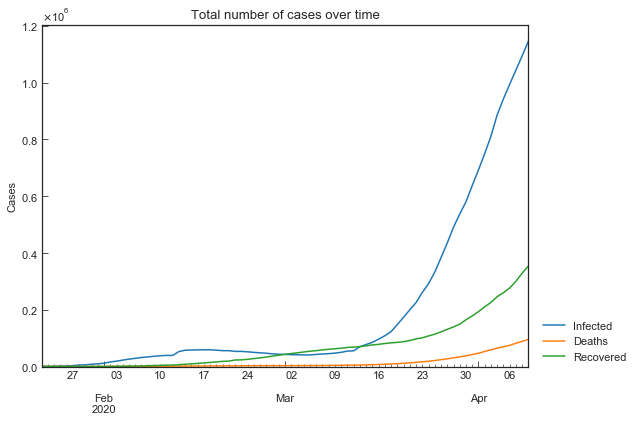

In [47]:
line_plot(total_df[data_cols], "Total number of cases over time")

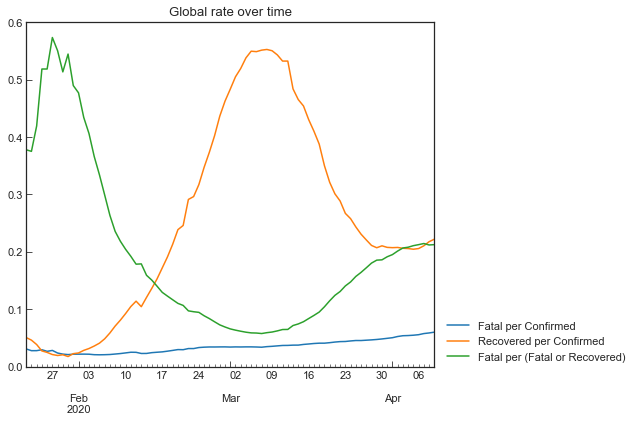

In [48]:
line_plot(total_df[rate_cols], "Global rate over time", ylabel="", math_scale=False)

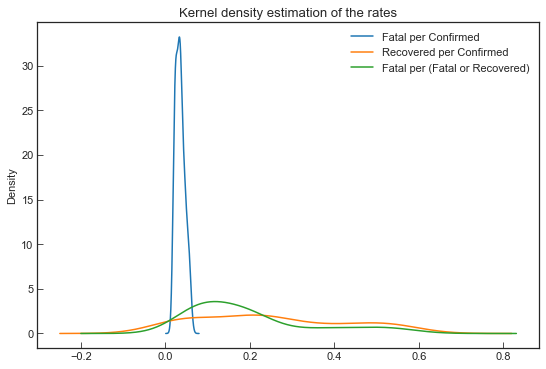

In [49]:
total_df[rate_cols].plot.kde()
plt.title("Kernel density estimation of the rates")
plt.show()

In [50]:
total_df[rate_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Fatal per Confirmed,79.0,0.034807,0.010747,0.020408,0.025174,0.034031,0.042056,0.059833
Recovered per Confirmed,79.0,0.250038,0.174454,0.017365,0.098275,0.213125,0.394883,0.552602
Fatal per (Fatal or Recovered),79.0,0.195894,0.143894,0.057464,0.086042,0.156953,0.213371,0.573427


## Data cleaning: Linelist (COVID19_open_line_list.csv)

In [51]:
linelist_open_raw = pd.read_csv("../input/novel-corona-virus-2019-dataset/COVID19_open_line_list.csv")
linelist_open_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14126 entries, 0 to 14125
Data columns (total 45 columns):
ID                          13173 non-null float64
age                         1349 non-null object
sex                         1264 non-null object
city                        10194 non-null object
province                    12906 non-null object
country                     13148 non-null object
wuhan(0)_not_wuhan(1)       13170 non-null float64
latitude                    13147 non-null float64
longitude                   13147 non-null float64
geo_resolution              13147 non-null object
date_onset_symptoms         746 non-null object
date_admission_hospital     730 non-null object
date_confirmation           13089 non-null object
symptoms                    493 non-null object
lives_in_Wuhan              565 non-null object
travel_history_dates        503 non-null object
travel_history_location     758 non-null object
reported_market_exposure    35 non-null object
addi

In [52]:
df = linelist_open_raw.loc[:, ~linelist_open_raw.columns.str.startswith("Unnamed:")]
df = df.dropna(axis=0, how="all")
df = df.drop(
    [
        # Unnecessary in this notebook
        "ID", "wuhan(0)_not_wuhan(1)", "admin3", "admin2", "admin1", "country_new", "admin_id",
        "data_moderator_initials", "source", "location", "lives_in_Wuhan", "notes_for_discussion",
        "sequence_available", "reported_market_exposure",
        # Maybe useful, but un-used
        "city", "latitude", "longitude", "geo_resolution", "additional_information",
        "travel_history_dates", "travel_history_location", 
    ],
    axis=1
)
# Personal
age = linelist_open_raw["age"].str.split("-", expand=True)
age[0] = pd.to_numeric(age[0], errors="coerce")
age[1] = pd.to_numeric(age[1], errors="coerce")
df["Age"] = age.mean(axis=1)
df["Age"] = df["Age"].fillna(df["Age"].median()).astype(np.int64)
df["Sex"] = df["sex"].fillna("-").str.replace("4000", "-").str.capitalize()
# Place
df["Country"] = df["country"].fillna("-")
df["Province"] = df["province"].fillna("-")
# Onset Date
series = df["date_onset_symptoms"].str.replace("end of December 2019", "31.12.2019").replace("-25.02.2020", "25.02.2020")
series = series.replace("20.02.220", "20.02.2020").replace("none", np.NaN).replace("10.01.2020 - 22.01.2020", np.NaN)
df["Onset_date"] = pd.to_datetime(series)
# Hospitalized date
series = df["date_admission_hospital"].replace("18.01.2020 - 23.01.2020", np.NaN)
df["Hospitalized_date"] = pd.to_datetime(series)
# Confirmed date
series = df["date_confirmation"].replace("25.02.2020-26.02.2020", np.NaN)
df["Confirmed_date"] = pd.to_datetime(series)
# Symptoms/events
df["Symptoms"] = df["symptoms"].fillna("-").str.lower()
# Underlying disease
df["Underlying_disease"] = df[["chronic_disease_binary", "chronic_disease"]].apply(
    lambda x: "No" if x[0] == 0 else x[1] if x[1] is not np.NaN else "-",
    axis=1
).str.strip(";").str.replace("; ", ",").str.replace(", ", ",")
# Outcome
df["Outcome"] = df["outcome"].replace(
    {
        "discharge": "discharged", "Discharged": "discharged", "death": "died",
        "critical condition, intubated as of 14.02.2020": "severe",
        "treated in an intensive care unit (14.02.2020)": "severe", "05.02.2020": "-",
        "Symptoms only improved with cough. Currently hospitalized for follow-up.": "stable"
    }
).fillna("-")
series = df["date_death_or_discharge"].replace("discharge", np.NaN)
df["Closed_date"] = pd.to_datetime(series)
# Show
use_cols = [
    "Age", "Sex", "Country", "Province", "Onset_date", "Hospitalized_date", "Confirmed_date", 
    "Symptoms", "Underlying_disease", "Outcome", "Closed_date"
]
open_linelist_df = df.loc[:, use_cols]
open_linelist_df.head()

,Age,Sex,Country,Province,Onset_date,Hospitalized_date,Confirmed_date,Symptoms,Underlying_disease,Outcome,Closed_date
0,30,Male,China,Anhui,2020-01-18,2020-01-20,2020-01-22,-,-,-,NaT
1,47,Male,China,Anhui,2020-10-01,2020-01-21,2020-01-23,-,-,-,NaT
2,49,Male,China,Anhui,2020-01-15,2020-01-20,2020-01-23,-,-,-,NaT
3,47,Female,China,Anhui,2020-01-17,2020-01-20,2020-01-23,-,-,-,NaT
4,50,Female,China,Anhui,2020-10-01,2020-01-21,2020-01-23,-,-,-,NaT


## Data cleaning: Linelist (COVID19_line_list_data.csv)
Linelist in clinical trials is a list of many case reports.

In [53]:
linelist_raw = pd.read_csv("../input/novel-corona-virus-2019-dataset/COVID19_line_list_data.csv")
linelist_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 27 columns):
id                       1085 non-null int64
case_in_country          888 non-null float64
reporting date           1084 non-null object
Unnamed: 3               0 non-null float64
summary                  1080 non-null object
location                 1085 non-null object
country                  1085 non-null object
gender                   902 non-null object
age                      843 non-null float64
symptom_onset            563 non-null object
If_onset_approximated    560 non-null float64
hosp_visit_date          507 non-null object
exposure_start           128 non-null object
exposure_end             341 non-null object
visiting Wuhan           1085 non-null int64
from Wuhan               1081 non-null float64
death                    1085 non-null object
recovered                1085 non-null object
symptom                  270 non-null object
source                   108

In [54]:
linelist_raw.head()

,id,case_in_country,reporting date,Unnamed: 3,summary,location,country,gender,age,symptom_onset,...,recovered,symptom,source,link,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,1,NaN,1/20/2020,NaN,"First confirmed imported COVID-19 pneumonia patient in Shenzhen (from Wuhan): male, 66, shenzheng residence, visited relatives in Wuhan on 12/29/2019, symptoms onset on 01/03/2020, returned to Shenzhen and seek medical care on 01/04/2020, hospitalized on 01/11/2020, sample sent to China CDC for testing on 01/18/2020, confirmed on 01/19/2020. 8 others under medical observation, contact tracing ongoing.","Shenzhen, Guangdong",China,male,66.0,01/03/20,...,0,NaN,Shenzhen Municipal Health Commission,http://wjw.sz.gov.cn/wzx/202001/t20200120_18987787.htm,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,1/20/2020,NaN,"First confirmed imported COVID-19 pneumonia patient in Shanghai (from Wuhan): female, 56, Wuhan residence, arrived in Shanghai from Wuhan on 01/12/2020, symptom onset and visited fever clinic on 01/15/2020, laboratory confirmed on 01/20/2020",Shanghai,China,female,56.0,1/15/2020,...,0,NaN,Official Weibo of Shanghai Municipal Health Commission,https://www.weibo.com/2372649470/IqogQhgfa?from=page_1001062372649470_profile&wvr=6&mod=weibotime&type=comment,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,1/21/2020,NaN,"First confirmed imported cases in Zhejiang: patient is male, 46, lives in Wuhan, self-driving from Wuhan to Hangzhou on 01/03/2020, symptom onset 01/04/2020, hospitalized on 01/17/2020, sample deliver to China CDC for testing on 01/20/2020, test positive on 01/21/2020.",Zhejiang,China,male,46.0,01/04/20,...,0,NaN,Health Commission of Zhejiang Province,http://www.zjwjw.gov.cn/art/2020/1/21/art_1202101_41786033.html,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,1/21/2020,NaN,"new confirmed imported COVID-19 pneumonia in Tianjin: female, age 60, recently visited Wuhan, visited fever clinic on 01/19/2020 in Tianjin then quarantined immediately.",Tianjin,China,female,60.0,NaN,...,0,NaN,人民日报官方微博,https://m.weibo.cn/status/4463235401268457?,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,1/21/2020,NaN,"new confirmed imported COVID-19 pneumonia in Tianjin: male, age 58, visited fever clinic on 01/14/2020.",Tianjin,China,male,58.0,NaN,...,0,NaN,人民日报官方微博,https://m.weibo.cn/status/4463235401268457?,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
df = linelist_raw.loc[:, ~linelist_raw.columns.str.startswith("Unnamed:")]
df = df.drop(["id", "case_in_country", "summary", "source", "link"], axis=1)
# Date
case_date_dict = {
    "reporting date": "Confirmed_date",
    "exposure_start": "Exposed_date",
    "exposure_end": "Quarantined_date",
    "hosp_visit_date": "Hospitalized_date",
    "symptom_onset": "Onset_date",
    "death": "Deaths_date",
    "recovered": "Recovered_date"    
}
df["death"] = df["death"].replace({"0": "", "1": ""})
df["recovered"] = df["recovered"].replace({"0": "", "1": "", "12/30/1899": "12/30/2019"})
for (col, _) in case_date_dict.items():
    df[col] = pd.to_datetime(df[col])
df = df.rename(case_date_dict, axis=1)
# Location
df["Country"] = df["country"].fillna("-")
df["Province"] = df["location"].fillna("-")
df["Province"] = df[["Country", "Province"]].apply(lambda x: "-" if x[0] == x[1] else x[1], axis=1)
# Personal
df["Gender"] = df["gender"].fillna("-").str.capitalize()
df["Age"] = df["age"].fillna(df["age"].median()).astype(np.int64) ## Fill in NA with median
df["From_Wuhan"] = df["from Wuhan"]
df["To_Wuhan"] = df["visiting Wuhan"]
# Medical
df["Events"] = df["symptom"].fillna("-")
# Order of columns
linelist_df = df.loc[
    :,
    [
        "Country", "Province",
        "Exposed_date", "Onset_date", "Hospitalized_date", "Confirmed_date", "Quarantined_date", "Deaths_date", "Recovered_date",
        "Events",
        "Gender", "Age", "From_Wuhan", "To_Wuhan"
    ]
]
linelist_df.tail()

,Country,Province,Exposed_date,Onset_date,Hospitalized_date,Confirmed_date,Quarantined_date,Deaths_date,Recovered_date,Events,Gender,Age,From_Wuhan,To_Wuhan
1080,Austria,Innsbruck,NaT,NaT,NaT,2020-02-25,NaT,NaT,NaT,-,-,24,0.0,0
1081,Afghanistan,-,NaT,NaT,NaT,2020-02-24,NaT,NaT,NaT,-,-,35,0.0,0
1082,Algeria,-,NaT,NaT,NaT,2020-02-26,2020-02-17,NaT,NaT,-,Male,51,0.0,0
1083,Croatia,-,2020-02-19,NaT,NaT,2020-02-25,2020-02-21,NaT,NaT,-,Male,51,0.0,0
1084,Switzerland,Bern,2020-02-15,2020-02-17,NaT,2020-02-25,2020-02-15,NaT,NaT,-,Male,70,0.0,0


In [56]:
linelist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 14 columns):
Country              1085 non-null object
Province             1085 non-null object
Exposed_date         128 non-null datetime64[ns]
Onset_date           563 non-null datetime64[ns]
Hospitalized_date    507 non-null datetime64[ns]
Confirmed_date       1084 non-null datetime64[ns]
Quarantined_date     341 non-null datetime64[ns]
Deaths_date          21 non-null datetime64[ns]
Recovered_date       152 non-null datetime64[ns]
Events               1085 non-null object
Gender               1085 non-null object
Age                  1085 non-null int64
From_Wuhan           1081 non-null float64
To_Wuhan             1085 non-null int64
dtypes: datetime64[ns](7), float64(1), int64(2), object(4)
memory usage: 118.8+ KB


In [57]:
linelist_df.describe(include="all").fillna("-")

,Country,Province,Exposed_date,Onset_date,Hospitalized_date,Confirmed_date,Quarantined_date,Deaths_date,Recovered_date,Events,Gender,Age,From_Wuhan,To_Wuhan
count,1085,1085,128,563,507,1084,341,21,152,1085,1085,1085,1081,1085
unique,38,135,37,62,58,43,50,12,30,109,3,-,-,-
top,China,-,2020-01-26 00:00:00,2020-01-23 00:00:00,2020-01-23 00:00:00,2020-02-27 00:00:00,2020-01-22 00:00:00,2020-02-23 00:00:00,2020-02-19 00:00:00,-,Male,-,-,-
freq,197,464,14,29,34,91,35,4,13,815,520,-,-,-
first,-,-,2019-12-17 00:00:00,2019-12-10 00:00:00,2019-12-27 00:00:00,2020-01-13 00:00:00,2020-01-02 00:00:00,2020-02-01 00:00:00,2019-12-30 00:00:00,-,-,-,-,-
last,-,-,2020-02-21 00:00:00,2020-02-26 00:00:00,2020-02-28 00:00:00,2020-02-28 00:00:00,2020-02-25 00:00:00,2020-02-28 00:00:00,2020-02-28 00:00:00,-,-,-,-,-
mean,-,-,-,-,-,-,-,-,-,-,-,49.8212,0.144311,0.176959
std,-,-,-,-,-,-,-,-,-,-,-,16.1036,0.351567,0.38181
min,-,-,-,-,-,-,-,-,-,-,-,0,0,0
25%,-,-,-,-,-,-,-,-,-,-,-,39,0,0


In [58]:
period_df = select_area(linelist_df, group=None)
period_df = period_df.loc[:, ["Exposed_date", "Onset_date", "Confirmed_date"]]
period_df["Latent [min]"] = (period_df["Onset_date"] - period_df["Exposed_date"]).dt.total_seconds() / 60
period_df["Waiting [min]"] = (period_df["Confirmed_date"] - period_df["Onset_date"]).dt.total_seconds() / 60
period_df["Latent [day]"] = period_df["Latent [min]"] / 60 / 24
period_df["Waiting [day]"] = period_df["Waiting [min]"] / 60 / 24
period_df["Latent + Waiting [day]"] = period_df["Latent [day]"] + period_df["Waiting [day]"]
period_df.dropna(axis=0).tail()

,Exposed_date,Onset_date,Confirmed_date,Latent [min],Waiting [min],Latent [day],Waiting [day],Latent + Waiting [day]
948,2020-01-25,2020-02-24,2020-02-24,43200.0,0.0,30.0,0.0,30.0
949,2020-01-25,2020-02-04,2020-02-24,14400.0,28800.0,10.0,20.0,30.0
957,2020-01-25,2020-02-12,2020-02-26,25920.0,20160.0,18.0,14.0,32.0
958,2020-01-25,2020-02-17,2020-02-26,33120.0,12960.0,23.0,9.0,32.0
1084,2020-02-15,2020-02-17,2020-02-25,2880.0,11520.0,2.0,8.0,10.0


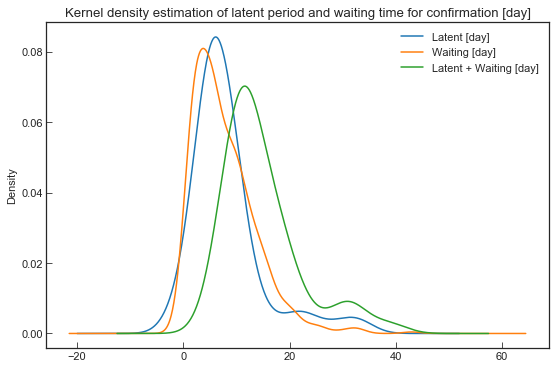

,count,mean,std,min,25%,50%,75%,max
Latent [day],83.0,8.180723,6.786185,-2.0,4.0,6.0,9.0,34.0
Waiting [day],563.0,7.682060,5.890473,0.0,3.0,6.0,11.0,43.0
Latent + Waiting [day],83.0,14.819277,7.305435,5.0,10.0,13.0,17.5,40.0


In [59]:
cols = ["Latent [day]", "Waiting [day]", "Latent + Waiting [day]"]
period_df[cols].plot.kde()
plt.title("Kernel density estimation of latent period and waiting time for confirmation [day]")
plt.show()
period_df[cols].describe().T

## Measures in each country

In [60]:
action_raw = dd.read_csv(
    "../input/covid19-containment-and-mitigation-measures/COVID 19 Containment measures data.csv"
).compute()
action_raw.head()

,ID,Applies To,Country,Date Start,Date end intended,Description of measure implemented,Exceptions,Implementing City,Implementing State/Province,Keywords,Quantity,Source,Target city,Target country,Target region,Target state
0,163,NaN,Austria,"Mar 16, 2020",NaN,On 10 March 2020 government announced that all universities will close their classes at the latest by 16 March.,NaN,NaN,NaN,university closure,NaN,https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Austria,NaN,NaN,NaN,NaN
1,132,NaN,Germany,"Feb 01, 2020",NaN,"102 German citizens and 26 relatives, all of whom were symptom-free on departure, were evacuated from the Wuhan region to Frankfurt am Main by the Executive Transport Wing of the German Air Force. After their return, they were placed in quarantine in a military barrack in Rhineland-Palatinate for 14 days.[716] The coronavirus was found in two passengers on 2 February.",NaN,NaN,NaN,"international traveller quarantine - risk countries, traveller testing",0.0001,https://www.tagesschau.de/inland/coronavirus-germersheim-107.html,NaN,NaN,NaN,NaN
2,578,NaN,United Kingdom,"Mar 20, 2020",NaN,"All schools, nurseries and colleges closed.",NaN,NaN,NaN,"nursery school closure, school closure, university closure",NaN,https://www.theguardian.com/world/2020/mar/18/coronavirus-school-colleges-nurseries-england-close-uk-friday,NaN,NaN,NaN,NaN
3,372,NaN,United Kingdom,"Mar 16, 2020",NaN,"If one person in any household has a persistent cough or fever, everyone living there must stay at home for 14 days",NaN,NaN,NaN,blanket isolation - symptoms,NaN,https://www.bbc.com/news/uk-51920444,NaN,NaN,NaN,NaN
4,357,NaN,United Kingdom,"Mar 16, 2020",NaN,"By the weekend, those with the most serious health conditions must be ""largely shielded from social contact for around 12 weeks""",NaN,NaN,NaN,isolation advice to elderly,NaN,https://www.bbc.com/news/uk-51920444,NaN,NaN,NaN,NaN


In [61]:
df  = action_raw.copy()
df = df.rename(
    {
        "Description of measure implemented": "Details",
        "Implementing State/Province": "Province",
    },
    axis=1
)
# Country/Province
df["Country"] = df["Country"].replace({"United Kingdom": "UK"})
df["Country"] = df["Country"].str.replace("US: ", "US/").str.replace("US:", "US/")
df = df.loc[~df["Country"].isnull(), :]
df["Province"] = df["Province"].fillna("-")
df[["Country", "Province", "-"]] = (df["Country"] + "/" + df["Province"]).str.split("/", expand=True)
# Date
df["Start_date"] = pd.to_datetime(df["Date Start"])
df["End_date"] = pd.to_datetime(df["Date end intended"])
df = df.loc[~df["Start_date"].isnull(), :]
# Detail
df = df.loc[~df["Details"].isnull(), :]
df["Keywords"] = df["Keywords"].fillna("-")
df["Exceptions"] = df["Exceptions"].fillna("-")
# _df = df["Keywords"].str.split(", ", expand=True)
# df = pd.concat([df, _df], axis=1)
# Save
df = df.loc[:, ["Country", "Province", "Start_date", "End_date", "Keywords", "Details", "Exceptions"]]
df = df.sort_values(["Start_date", "End_date", "Country", "Province"])
action_df = df.copy()
action_df.head()

,Country,Province,Start_date,End_date,Keywords,Details,Exceptions
150,China,Hubei,2019-12-18,NaT,first case,Seven cases of COVID-19 documented in Wuhan,-
151,China,Hubei,2019-12-25,NaT,"compulsory isolation, confirmed case isolation",Medical staff in two Wuhan hospitals were suspected of contracting the virus; first reports of isolation being used,-
152,China,Hubei,2019-12-30,NaT,"case reporting, research, source tracing",Wuhan CDC confirmed 27 cases of viral pneumonia of unknown cause; all hospitals required to report all cases of unkown origin and related to Huanan Seafood Market and give patients proper treatment;,-
138,Hong Kong,-,2019-12-30,NaT,international traveller quarantine - risk countries,Hong Kong Secretary for Food and Health announced that suspected cases presenting with symptoms of pneumonia acute respiratory illness fever and a recent travel to Wuhan within the last 14 days would be put in isolation,-
149,Macau,-,2019-12-30,NaT,international traveller screening - all countries,Tightened inbound traveller screening,-


In [62]:
words = pd.Series(", ".join(action_df["Keywords"].tolist()).split(", ")).unique().tolist()
words

['first case',
 'compulsory isolation',
 'confirmed case isolation',
 'case reporting',
 'research',
 'source tracing',
 'international traveller quarantine - risk countries',
 'international traveller screening - all countries',
 'coronavirus education activities',
 'encouraging symptomatic people to seek tests',
 'international traveller screening - risk countries',
 'limited nonessential business suspension',
 'test travellers',
 'contacts traced total',
 'outbound travel warning',
 'public announcement',
 'special management arrangements',
 'task group',
 'hospital specialisation',
 'contact isolation - no symptoms',
 'contact tracing',
 'public mask and hygiene supply',
 'testing commenced',
 'international travel ban - risk countries',
 'international traveller screening - symptomatic',
 'general nonessential business suspension',
 'hygiene enforcement',
 'quarantine zone',
 'cluster isolation - no symptoms',
 'traveller testing',
 'wild animal ban',
 'phone line',
 'moves of med

In [63]:
vectorizer = TfidfVectorizer(use_idf=True)
vecs = vectorizer.fit_transform(words)
clusters = KMeans(n_clusters=20, random_state=0).fit_predict(vecs)
df = pd.DataFrame(
    {
        "Group": clusters,
        "Word": words
    }
)
df = df.sort_values("Group")
df = pd.DataFrame(df.groupby("Group")["Word"].apply(lambda x: ", ".join(x)))
df

,Word
Group,
0,"sentence, epidemic data, ban on visit to nursing homes, intellectual property, unemployment benefits extension, medical staff protective equipment, handwashing encouragement, retired doctors called, restaurant limitations, eviction moratorium, activism for stricter measures, first death, military takeover, outdoor gatherings banned, manufacturing capacity, economic stimulus, emergency declaration, weddings canceled, riots, social distancing, prisons closed to visitors, business resumed, quaratine violation, price gouging ban, -, total vehicle ban, community spread, low compliance, prisoner release, sewing plain clothes masks, army deployed, indoor person density, financial incentive, visa suspension, cash cleaning, clinic specialisation, symptom hotline, protective equipment supplies, indoor gatherings banned, medical aid, mitigation focus, elderly, economic incentives, wild animal ban, looking for children, evictions prohibited, shopping vouchers, space minimum, exam postpone, hea..."
1,"airport closure, school closure - limited, public green closure, closure of gathering places, closure nonessential stores, school closure, university closure, nursery school closure"
2,"domestic traveller screening, international traveller quarantine - risk countries, international traveller screening - all countries, international traveller screening - risk countries, outbound traveller ban, international aid, international travel ban - all countries, international travel ban - risk countries, international traveller screening - symptomatic, international traveller quarantine - all countries"
3,"activity cancellation - other, court cancellation, religious activity limitations, very large event cancellation or postponement, sports cancellation, event cancellation - other, cultural activity limitation, religious activity cancellation"
4,"compulsory isolation, symptom isolation, contact isolation, discharged patient isolation, voluntary isolation, contact tracing, contact isolation - no symptoms, social isolation, contact isolation - symptoms, isolation allowance"
5,"test contacts, test travellers, test inpatients, test symptomatic, test cohorts, test vulnerable, contacts traced total"
6,"remote work - limited, remote work, remote schooling - limited, remote schooling, mandated remote schooling, mandated remote work, remote cultural content"
7,"blanket text messaging, cluster isolation - no symptoms, blanket curfew - no symptoms, blanket announcement, blanket isolation - symptoms, cohort isolation - no symptoms, blanket isolation - no symptoms"
8,"end of testing, testing, testing numbers total, testing planned, testing commenced, expansion of testing facilities, new testing method commenced, traveller testing"


## Measures in Italy

In [64]:
ita_action_raw = pd.read_excel(
    "../input/covid19-prevention-in-italy/Dataset_Italy_COVID_19.xlsx",
    sheet_name="Foglio1"
)
ita_action_raw.head()

,Country,Region,Village,Start date,End Date,Action,Detail,Number of people,link
0,Italy,NaN,NaN,30-jan-2020,NaN,Restriction of entry,All flights to and from China have been suspended,NaN,http://www.governo.it/it/approfondimento/coronavirus/13968
1,Italy,NaN,NaN,03-feb-2020,NaN,Leave from epidemic area,Return of people present in countries at risk and return of foreign citizens to the countries of origin exposed to the risk,NaN,http://www.governo.it/it/approfondimento/coronavirus/13969
2,Italy,NaN,NaN,06-feb-2020,NaN,Control in the Airport,Airport monitoring and control for domestic and international flights,62000,http://www.governo.it/it/approfondimento/coronavirus/13970
3,Italy,NaN,NaN,21-feb-2020,21-feb-2020,Quaranteene,"Mandatory quarantine isolation for close contacts with a positive cases, and provides active surveillance with fiduciary home permanence for those who have been in risk areas in the last 14 days",NaN,http://www.governo.it/it/approfondimento/coronavirus/13971
4,Italy,"Lombardia,Veneto","Vo’ Euganeo (Veneto) e Codogno, Castiglione d’Adda, Casalpusterlengo, Fombio, Maleo, Somaglia, Bertonico, Terranova dei Passerini, Castelgerundo e San Fiorano (Lombardia)",23-feb-2020,NaN,containment and management the Italian infected areas,decree-law introducing urgent measures regarding the containment and management of the epidemiological emergency from COVID-2019.,53856‬,http://www.governo.it/it/approfondimento/coronavirus/13972


In [65]:
df = ita_action_raw.copy()
df = df.drop(["Country", "Village", "link"], axis=1)
df.columns = [col.capitalize().replace(" ", "_") for col in df.columns]
df["Start_date"] = pd.to_datetime(df["Start_date"])
df["End_date"] = pd.to_datetime(df["End_date"])
df["Region"] = df["Region"].fillna("-")
df["Number_of_people"] = df["Number_of_people"].fillna(-1)
ita_action_df = df.copy()
ita_action_df.tail()

,Region,Start_date,End_date,Action,Detail,Number_of_people
6,All,2020-03-04,2020-03-15,Close school and university,relative decree-law containing further measures to combat and contain the spread of the COVID-19 virus throughout the country,8466064
7,"Emilia Romagna,Friuli Venezia Giulia, Lombardia, Veneto, Piemonte e Liguria,",2020-03-07,2020-03-07,more containment and management the Italian infected areas,"prohibit any movement in Lombardy and in fourteen provinces of Veneto, Emilia Romagna, Piedmont, Marche.",-1
8,-,2020-03-09,2020-04-13,lockdown,people must stay at home and go out only for food or work needs. Many activities are closed and only the essential ones remain open.,60483973
9,-,2020-03-19,NaT,Medicine sperimentation,"testing began on the drug Tocilizumab, a drug used against rheumatoid arthritis that has had beneficial effects against COVID-19 in China.",330
10,-,2020-03-20,NaT,task force,create a task force of doctors from all over Italy to be able to send to the territories with the greatest health problems.,-1


## The number of cases in Japan

In [66]:
jpn_ncov_raw = pd.read_csv("../input/covid19-dataset-in-japan/covid_jpn_total.csv")
jpn_ncov_raw.tail()

,Date,Location,Positive,Tested,Symptomatic,Asymptomatic,Sym-unknown,Hosp_mild,Hosp_severe,Hosp_unknown,Hosp_waiting,Discharged,Fatal
149,2020-04-08,Airport,74,7768.0,24,50,0,72,0,0,0,2,0
150,2020-04-08,Returnee,15,829.0,11,4,0,0,0,0,0,15,0
151,2020-04-09,Domestic,4667,54284.0,3069,335,1263,2143,109,356,43,668,85
152,2020-04-09,Airport,86,9274.0,29,57,0,84,0,0,0,2,0
153,2020-04-09,Returnee,15,829.0,11,4,0,0,0,0,0,15,0


In [67]:
# https://www.kaggle.com/lisphilar/eda-of-japan-dataset
# and remove returunee/airport cases
df = jpn_ncov_raw.copy()
df.dropna(how="any", inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df = df.groupby("Location").apply(
    lambda x: x.set_index("Date").resample("D").interpolate(method="linear")
)
df = df.drop("Location", axis=1).reset_index()
df = df.loc[df["Location"] == "Domestic", :].drop("Location", axis=1)
df = df.set_index("Date").resample("D").last().fillna("ffill")
sel = df.columns.isin(["Location", "Date"])
df.loc[:, ~sel] = df.loc[:, ~sel].astype(np.int64)
jpn_ncov_df = df.copy()
jpn_ncov_df.tail()

,Positive,Tested,Symptomatic,Asymptomatic,Sym-unknown,Hosp_mild,Hosp_severe,Hosp_unknown,Hosp_waiting,Discharged,Fatal
Date,,,,,,,,,,,
2020-04-05,3191,40263,2205,278,708,1389,70,373,13,568,70
2020-04-06,3569,40481,2395,289,885,1551,79,386,20,575,73
2020-04-07,3817,48357,2551,294,972,1631,80,414,35,605,80
2020-04-08,4168,52901,2771,306,1091,1865,99,378,39,615,81
2020-04-09,4667,54284,3069,335,1263,2143,109,356,43,668,85


# Grouping by growth factor
The number of confirmed cases is increasing in many countries, but there are two of countries. In a first-type country, growth factor is larger than 1 and the number of cases is rapidly increasing. In a second-type country, growth factor is less than 1.

## Calculate growth factor
Where $C$ is the number of confirmed cases,  
$$\mathrm{Growth\ Factor} = \cfrac{\Delta \mathrm{C}_{n}}{\Delta \mathrm{C}_{n-1}}$$

In [68]:
df = ncov_df_ungrouped.pivot_table(
    index="Date", columns="Country", values="Confirmed", aggfunc="sum"
).fillna(method="ffill").fillna(0)
# Growth factor: (delta Number_n) / (delta Number_n)
df = df.diff() / df.diff().shift(freq="D")
df = df.replace(np.inf, np.nan).fillna(1.0)
# Rolling mean (window: 7 days)
df = df.rolling(7).mean()
df = df.iloc[6:-1, :]
# round: 0.01
growth_value_df = df.round(2)
growth_value_df.tail()

Country,Azerbaijan,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,...,Uruguay,Uzbekistan,Vatican City,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Zambia,Zimbabwe,occupied Palestinian territory
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-05,1.0,3.81,1.15,1.11,1.52,0.86,1.14,1.22,1.46,1.0,...,1.30,1.77,1.0,1.00,0.88,1.52,1.00,1.71,0.71,1.0
2020-04-06,1.0,3.14,1.12,1.14,1.42,0.93,1.14,1.17,1.00,1.0,...,1.41,1.97,1.0,1.07,1.30,1.55,0.86,1.00,0.71,1.0
2020-04-07,1.0,3.58,0.92,0.94,1.52,0.86,1.14,0.83,1.14,1.0,...,1.17,1.39,1.0,1.07,1.36,1.55,0.86,1.14,0.71,1.0
2020-04-08,1.0,1.38,1.21,1.13,1.32,1.00,1.00,1.00,1.23,1.0,...,1.17,1.39,1.0,1.07,1.34,0.88,0.86,1.14,0.71,1.0
2020-04-09,1.0,1.57,1.12,1.11,1.07,1.00,1.00,0.98,1.09,1.0,...,1.17,1.23,1.0,1.30,1.26,0.62,0.86,0.86,0.71,1.0


## Grouping countires based on growth factor
* Outbreaking: growth factor $>$ 1 for the last 7 days
* Stopping: growth factor $<$ 1 for the last 7 days
* At a crossroad: the others

In [69]:
df = growth_value_df.copy()
df = df.iloc[-7:, :].T
day_cols = df.columns.strftime("%d%b%Y")
df.columns = day_cols
last_date = day_cols[-1]
# Grouping
more_col, less_col = "GF > 1 [straight days]", "GF < 1 [straight days]"
df[more_col] = (growth_value_df > 1).iloc[::-1].cumprod().sum(axis=0)
df[less_col] = (growth_value_df < 1).iloc[::-1].cumprod().sum(axis=0)
df["Group"] = df[[more_col, less_col]].apply(
    lambda x: "Outbreaking" if x[0] >= 7 else "Stopping" if x[1] >= 7 else "Crossroad",
    axis=1
)
# Sorting
df = df.loc[:, ["Group", more_col, less_col, *day_cols]]
df["rank1"] = df[more_col] * df[last_date]
df["rank2"] = df[less_col] * df[last_date]
df = df.sort_values(["Group", "rank1", "rank2"], ascending=False)
df = df.drop(["rank1", "rank2"], axis=1)
growth_df = df.copy()
growth_df.head()

,Group,GF > 1 [straight days],GF < 1 [straight days],03Apr2020,04Apr2020,05Apr2020,06Apr2020,07Apr2020,08Apr2020,09Apr2020
Country,,,,,,,,,,
Mongolia,Stopping,0,30,0.71,0.71,0.86,0.86,0.71,0.71,0.71
Sudan,Stopping,0,27,0.79,0.64,0.71,0.71,0.71,0.71,0.71
Nicaragua,Stopping,0,21,0.71,0.71,0.86,0.71,0.71,0.86,0.86
Congo (Brazzaville),Stopping,0,25,0.71,0.71,0.71,0.71,0.71,0.71,0.71
Equatorial Guinea,Stopping,0,25,0.86,0.71,0.71,0.71,0.71,0.71,0.71


In [70]:
df = pd.merge(ncov_df_ungrouped, growth_df["Group"].reset_index(), on="Country")
ncov_df = df.loc[:, ["Date", "Group", *ncov_df_ungrouped.columns[1:]]]
ncov_df.tail()

,Date,Group,Country,Province,Confirmed,Infected,Deaths,Recovered
13524,2020-04-09,Crossroad,Western Sahara,-,4,4,0,0
13525,2020-04-06,Crossroad,Sao Tome and Principe,-,4,4,0,0
13526,2020-04-07,Crossroad,Sao Tome and Principe,-,4,4,0,0
13527,2020-04-08,Crossroad,Sao Tome and Principe,-,4,4,0,0
13528,2020-04-09,Crossroad,Sao Tome and Principe,-,4,4,0,0


## Group 1: Outbreaking, growth factor $>$ 1 for the last 7 days

In [71]:
pprint(growth_df.loc[growth_df["Group"] == "Outbreaking", :].index.tolist(), compact=True)

['India', 'Honduras', 'France', 'Canada', 'Sweden', 'Mauritius', 'Philippines',
 'US', 'Nigeria', 'Egypt', 'Latvia', 'Czech Republic', 'Bahrain', 'Serbia',
 'Malta', 'Burkina Faso', 'Luxembourg', 'Pakistan', 'Romania', 'Colombia',
 'Poland', 'Mexico', 'Kyrgyzstan', 'North Macedonia', 'Indonesia', 'Peru',
 'Kazakhstan', 'Cuba', 'Turkey', 'Russia', 'UK', 'Oman', 'Bulgaria', 'Senegal',
 'Iraq', 'Bolivia', 'Estonia', 'Ireland', 'Kuwait', 'Paraguay', 'Japan',
 'South Africa', 'Uzbekistan', 'Qatar', 'Uruguay', 'Guatemala', 'Azerbaijan',
 'Moldova', 'Afghanistan', 'Chile', 'Ivory Coast', 'Finland', 'Singapore',
 'Madagascar', 'Bangladesh', 'Sri Lanka', 'Georgia', 'Brazil', 'Saudi Arabia',
 'Belarus', 'Kenya', 'Cambodia', 'Jordan', 'Andorra', 'United Arab Emirates',
 'Morocco']


In [72]:
growth_df.loc[growth_df["Group"] == "Outbreaking", :].head()

,Group,GF > 1 [straight days],GF < 1 [straight days],03Apr2020,04Apr2020,05Apr2020,06Apr2020,07Apr2020,08Apr2020,09Apr2020
Country,,,,,,,,,,
India,Outbreaking,33,0,1.83,4.81,4.90,4.36,4.33,3.90,3.97
Honduras,Outbreaking,25,0,3.05,4.81,4.74,5.53,5.56,3.49,3.90
France,Outbreaking,44,0,1.24,1.76,1.70,1.71,1.77,1.73,1.84
Canada,Outbreaking,41,0,1.15,1.02,1.64,1.45,1.54,1.55,1.48
Sweden,Outbreaking,43,0,1.18,1.02,1.10,1.05,1.06,1.10,1.06


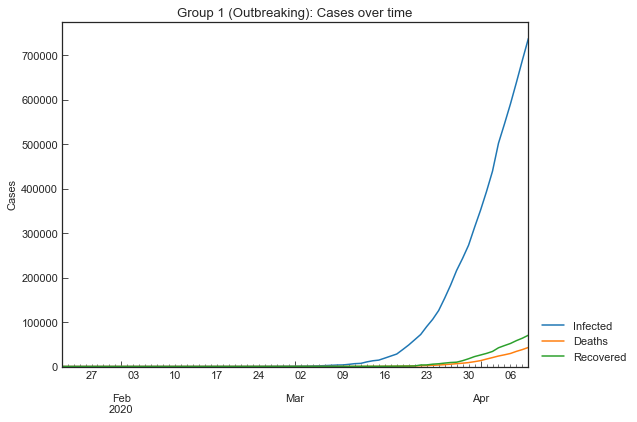

,Infected,Deaths,Recovered
Date,,,
2020-04-05,545823,26317,47093
2020-04-06,590924,29323,51823
2020-04-07,639462,34091,58259
2020-04-08,689597,38145,63750
2020-04-09,738303,42924,70475


In [73]:
df = ncov_df.loc[ncov_df["Group"] == "Outbreaking", ["Date", *data_cols]].groupby("Date").sum()
line_plot(df, "Group 1 (Outbreaking): Cases over time", y_integer=True)
df.tail()

## Group 2: Stopping, growth factor $<$ 1 for the last 7 days

In [74]:
pprint(growth_df.loc[growth_df["Group"] == "Stopping", :].index.tolist(), compact=True)

['Mongolia', 'Sudan', 'Nicaragua', 'Congo (Brazzaville)', 'Equatorial Guinea',
 'Bhutan', 'Tanzania', 'Mozambique', 'Belize', 'Saint Lucia', 'San Marino',
 'Cabo Verde', 'Syria', 'Dominica', 'Nepal', 'Chad', 'Holy See', 'Seychelles',
 'Guinea-Bissau', 'Namibia', 'Zimbabwe', 'Liechtenstein', 'Botswana',
 'Saint Kitts and Nevis', 'Eritrea', 'Italy', 'Austria', 'Burundi', 'Spain',
 'Iran', 'Burma', 'Sierra Leone', 'Benin', 'Jamaica', 'Fiji']


In [75]:
growth_df.loc[growth_df["Group"] == "Stopping", :].head()

,Group,GF > 1 [straight days],GF < 1 [straight days],03Apr2020,04Apr2020,05Apr2020,06Apr2020,07Apr2020,08Apr2020,09Apr2020
Country,,,,,,,,,,
Mongolia,Stopping,0,30,0.71,0.71,0.86,0.86,0.71,0.71,0.71
Sudan,Stopping,0,27,0.79,0.64,0.71,0.71,0.71,0.71,0.71
Nicaragua,Stopping,0,21,0.71,0.71,0.86,0.71,0.71,0.86,0.86
Congo (Brazzaville),Stopping,0,25,0.71,0.71,0.71,0.71,0.71,0.71,0.71
Equatorial Guinea,Stopping,0,25,0.86,0.71,0.71,0.71,0.71,0.71,0.71


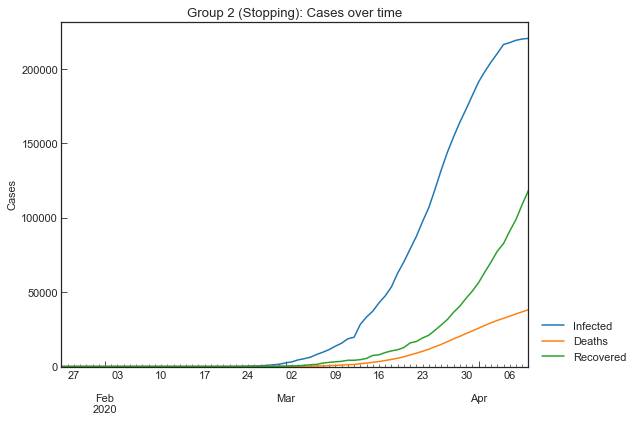

,Infected,Deaths,Recovered
Date,,,
2020-04-05,216565,32386,82697
2020-04-06,217837,33876,91100
2020-04-07,219423,35343,98824
2020-04-08,220253,36787,108980
2020-04-09,220711,38191,118344


In [76]:
df = ncov_df.loc[ncov_df["Group"] == "Stopping", ["Date", *data_cols]].groupby("Date").sum()
line_plot(df, "Group 2 (Stopping): Cases over time", y_integer=True)
df.tail()

## Group 3: At a crossroad, the others

In [77]:
pprint(growth_df.loc[growth_df["Group"] == "Crossroad", :].index.tolist(), compact=True)

['Kosovo', 'Djibouti', 'Ukraine', 'Togo', 'Guinea',
 'Saint Vincent and the Grenadines', 'Guyana', 'China', 'Monaco', 'Mali',
 'Slovakia', 'Netherlands', 'Venezuela', 'Hungary', 'Ethiopia', 'Vietnam',
 'Barbados', 'Belgium', 'Niger', 'Bosnia and Herzegovina', 'Greece', 'Bahamas',
 'Armenia', 'Haiti', 'Lebanon', 'Panama', 'Gabon', 'Somalia', 'El Salvador',
 'Albania', 'Algeria', 'Thailand', 'Portugal', 'Tunisia', 'Israel',
 'Costa Rica', 'Croatia', 'Laos', 'Cyprus', 'South Korea', 'Australia',
 'Central African Republic', 'Brunei', 'Ghana', 'Western Sahara',
 'Dominican Republic', 'South Sudan', 'Liberia', 'Papua New Guinea',
 'Sao Tome and Principe', 'Taiwan', 'Macau', 'Ecuador', 'Eswatini', 'Hong Kong',
 'Iceland', 'Trinidad and Tobago', 'Malawi', 'Norway', 'West Bank and Gaza',
 'Denmark', 'Slovenia', 'Argentina', 'Germany', 'Rwanda', 'Malaysia',
 'Cameroon', 'Montenegro', 'New Zealand', 'Uganda', 'Zambia', 'Congo',
 ' Azerbaijan', 'Angola', 'Antigua and Barbuda', 'Aruba', 'Bahamas, 

In [78]:
growth_df.loc[growth_df["Group"] == "Crossroad", :].head()

,Group,GF > 1 [straight days],GF < 1 [straight days],03Apr2020,04Apr2020,05Apr2020,06Apr2020,07Apr2020,08Apr2020,09Apr2020
Country,,,,,,,,,,
Kosovo,Crossroad,6,0,0.52,1.76,1.83,1.83,1.83,1.81,1.81
Djibouti,Crossroad,5,0,1.27,1.00,2.00,2.49,2.35,2.45,2.12
Ukraine,Crossroad,3,0,1.27,1.33,1.04,0.97,2.64,2.63,2.68
Togo,Crossroad,5,0,0.73,0.88,1.16,1.69,1.64,1.67,1.54
Guinea,Crossroad,6,0,0.92,1.18,1.08,1.07,1.39,1.43,1.25


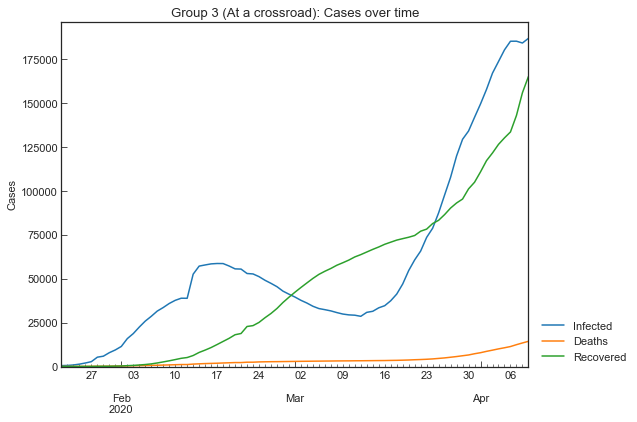

,Infected,Deaths,Recovered
Date,,,
2020-04-05,180341,10671,130222
2020-04-06,185260,11366,133592
2020-04-07,185292,12431,142971
2020-04-08,184255,13406,155931
2020-04-09,186906,14340,165156


In [79]:
df = ncov_df.loc[ncov_df["Group"] == "Crossroad", ["Date", *data_cols]].groupby("Date").sum()
line_plot(df, "Group 3 (At a crossroad): Cases over time", y_integer=True)
df.tail()

# Trend analysis
Using fbprophet package, we will find changing points of log10(comfirmed/deaths/recovered).  
We will use the data in the most cirical country where the number of days with growth factor $>$ 1 is the longest.

## Most critical country

In [80]:
critical_country = growth_df.loc[growth_df["Group"] == "Outbreaking", :].index[0]
critical_country

'India'

In [81]:
critical_df = ncov_df.loc[ncov_df["Country"] == critical_country, ["Date", *data_cols]].groupby("Date").sum()
critical_df.tail()

,Infected,Deaths,Recovered
Date,,,
2020-04-05,3260,99,229
2020-04-06,4267,136,375
2020-04-07,4740,150,421
2020-04-08,5232,178,506
2020-04-09,5879,226,620


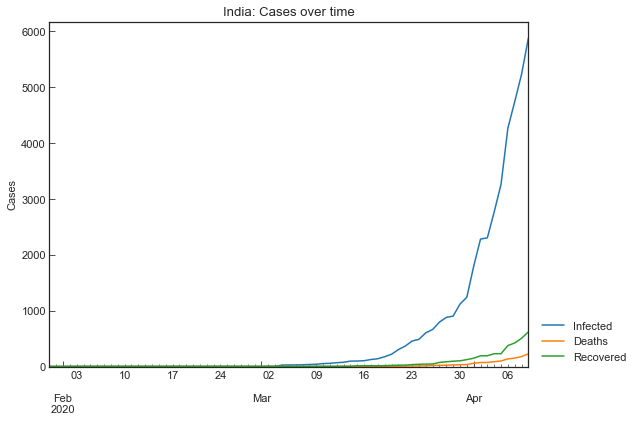

In [82]:
line_plot(critical_df, f"{critical_country}: Cases over time", y_integer=True)

## Trend of log10(Confirmed)

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


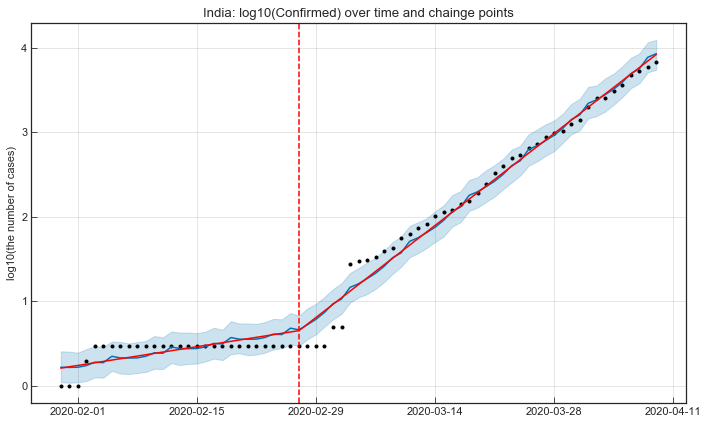

In [83]:
show_trend(ncov_df, variable="Confirmed", places=[(critical_country, None)])

**The slope was change at 09Mar2020.**
<!--**No slope change points were found for the number of confirmed cases.**-->
<!--**The incline of the number of confirmed cases slightly grow large on 01Mar2020. I will keep a watchful eye on the trend.**-->

## Trend of log10(Deaths)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


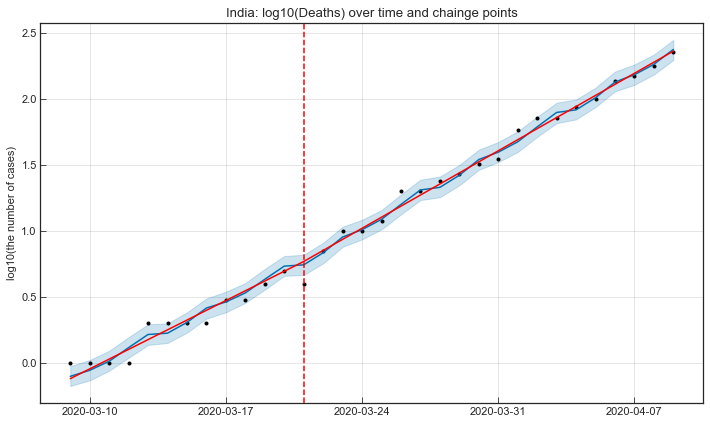

In [84]:
show_trend(ncov_df, variable="Deaths", places=[(critical_country, None)], start_date="09Mar2020")

**No slope change points were found for the number of fatal cases from 09Mar2020.**
<!--**Slope of the number of fatal cases was changed on 15Mar2020.**-->

## Trend of log10(Recovered)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


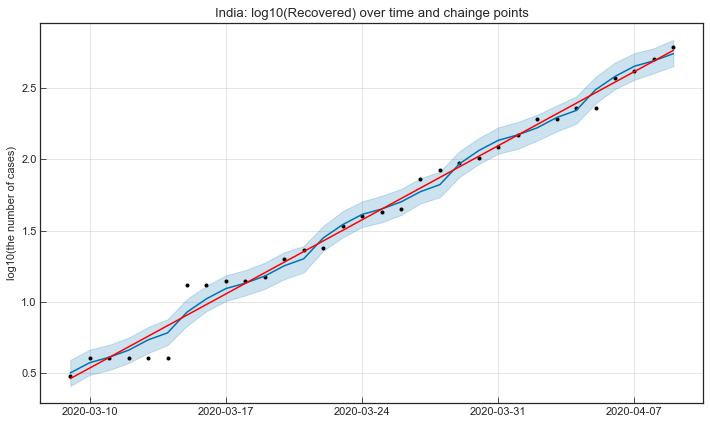

In [85]:
show_trend(ncov_df, variable="Recovered", places=[(critical_country, None)], start_date="09Mar2020")

**Slope change point was found on 18Mar2020.**
<!--**No slope change points were found for the number of recovered cases from 09Mar2020.**<-->

**Records after 18Mar2020 will be used for improvement of math model.**

In [86]:
critical_country_start = "18Mar2020"

# SIR to SIR-F
In this section, we will create a mathematical model derived from SIR model.

## Prediction with SIR model
To understand the trend of infection, we will use mathematical epidemic model. Let's start discussion using a basic model named SIR.

### What is SIR model?
SIR model is a simple mathematical model to understand outbreak of infectious diseases.  
[The SIR epidemic model - Learning Scientific Programming with Python](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/)

 * S: Susceptible (=All - Confirmed)
 * I: Infected (=Confirmed - Recovered - Deaths)
 * R: Recovered or fatal (=Recovered + Deaths)
 
Note: THIS IS NOT THE GENERAL MODEL!  
Though R in SIR model is "Recovered and have immunity", I defined "R as Recovered or fatal". This is because mortality rate cannot be ignored in the real COVID-19 data.

Model:  
S + I $\overset{\beta}{\longrightarrow}$ 2I  
I $\overset{\gamma}{\longrightarrow}$ R

$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery(+Mortality) rate [1/min]  

Ordinary Differential Equation (ODE):   
$\frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I$  
$\frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - \gamma I$  
$\frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I$  

Where $N=S+I+R$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR model
To simplify the model, we will remove the units of the variables from ODE.

Set $(S, I, R) = N \times (x, y, z)$ and $(T, \beta, \gamma) = (\tau t, \tau^{-1} \rho, \tau^{-1} \sigma)$.  

This results in the ODE  
$\frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y$  
$\frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - \sigma y$  
$\frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y$  

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
$0 < (x, y, z, \rho, \sigma) < 1$  
$1\leq \tau \leq 1440$  

Basic reproduction number, Non-dimentional parameter, is defined as  
$R_0 = \rho \sigma^{-1} = \beta \gamma^{-1}$  

Estimated Mean Values of $R_0$:  
$R_0$ means "the average number of secondary infections caused by an infected host" ([Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)).  
(Secondary data: [Van den Driessche, P., & Watmough, J. (2002).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002118))  
2.06: Zika in South America, 2015-2016  
1.51: Ebola in Guinea, 2014  
1.33: H1N1 influenza in South Africa, 2009  
3.5 : SARS in 2002-2003  
1.68: H2N2 influenza in US, 1957  
3.8 : Fall wave of 1918 Spanish influenza in Genova  
1.5 : Spring wave of 1918 Spanish influenza in Genova  

When $x=\frac{1}{R_0}$, $\frac{\mathrm{d}y}{\mathrm{d}t}=0$. This means that the max value of confirmed ($=y+z$) is $1-\frac{1}{R_0}$.

In [87]:
train_dataset = SIR.create_dataset(
    ncov_df, population_dict[critical_country], excluded_places=[(critical_country, None)],
    start_date=critical_country_start
)
train_start_date, train_initials, train_Tend, train_df = train_dataset
pprint([train_start_date.strftime("%d%b%Y"), train_initials, train_Tend])

['18Mar2020', array([9.99839612e-01, 9.16579537e-05, 6.87296490e-05]), 31680]


In [88]:
train_df.tail()

,T,x,y,z
18,25920,0.999053,0.000702,0.000246
19,27360,0.998999,0.000739,0.000262
20,28800,0.998939,0.000776,0.000285
21,30240,0.998876,0.000813,0.000311
22,31680,0.998814,0.000851,0.000335


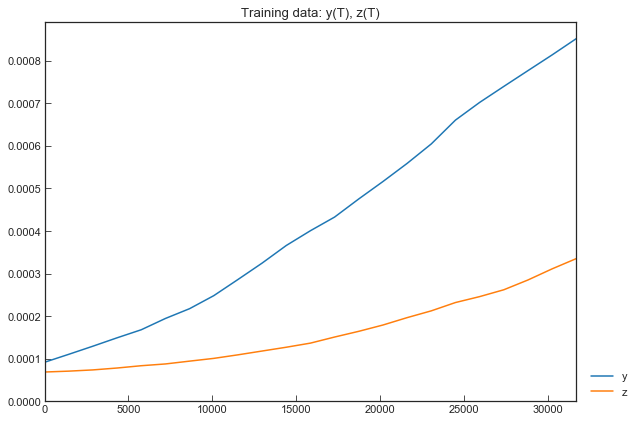

In [89]:
line_plot(
    train_df.set_index("T").drop("x", axis=1),
    "Training data: y(T), z(T)", math_scale=False, ylabel=""
)

**Note: We cannot convert $T$ to $t$ because $\tau$ has not been determined yet.**

### Example of non-dimensional SIR model
For example, set $R_0 = 2.5, \rho=0.2$.

In [90]:
eg_r0, eg_rho = (2.5, 0.2)
eg_sigma = eg_rho / eg_r0
(eg_rho, eg_sigma)

(0.2, 0.08)

In [91]:
%%time
eg_df = simulation(SIR, train_initials, step_n=200, rho=eg_rho, sigma=eg_sigma)

Wall time: 3 ms


In [92]:
eg_df.tail()

,t,x,y,z
196,196,0.107561,0.000669,0.891769
197,197,0.107547,0.000631,0.891821
198,198,0.107534,0.000595,0.891871
199,199,0.107522,0.000562,0.891917
200,200,0.107510,0.000530,0.891960


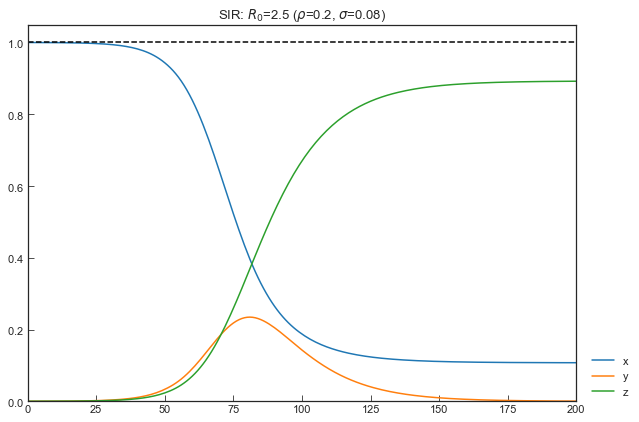

In [93]:
line_plot(
    eg_df.set_index("t"),
    title=r"SIR: $R_0$={0} ($\rho$={1}, $\sigma$={2})".format(eg_r0, eg_rho, eg_sigma),
    ylabel="",
    h=1
)

### Test of hyperparameter optimization using example data
To test the hyperparameter optimization functions defeined in this notebook, we will estimate the SIR model parameters using the example data and example $\tau=1440$ [min] and total population 1,000,000.

In [94]:
# Set the example conditions
eg_tau = 1440
eg_start_date = ncov_df["Date"].min()
eg_total_population = 1000000
# Create dataset in the format of ncov_df
eg_ori_df = pd.DataFrame(
    {
        "Date": (eg_df["t"] * eg_tau).apply(lambda x: timedelta(minutes=x)) + eg_start_date,
        "Country": "Example",
        "Province": "Example"
    }
)
eg_ori_df["Infected"] = (eg_df["y"] * eg_total_population).astype(np.int64)
eg_ori_df["Deaths"] = (eg_df["z"] * eg_total_population * 0.02).astype(np.int64)
eg_ori_df["Recovered"] = (eg_df["z"] * eg_total_population * 0.98).astype(np.int64)
eg_ori_df.tail()

,Date,Country,Province,Infected,Deaths,Recovered
196,2020-08-05,Example,Example,669,17835,873934
197,2020-08-06,Example,Example,631,17836,873985
198,2020-08-07,Example,Example,595,17837,874033
199,2020-08-08,Example,Example,561,17838,874078
200,2020-08-09,Example,Example,529,17839,874121


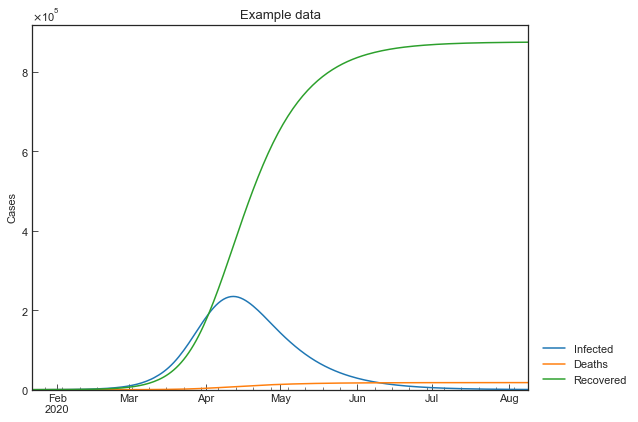

In [95]:
line_plot(eg_ori_df.set_index("Date")[data_cols], "Example data")

In [113]:
# %%time
# eg_sir_estimator = Estimator(SIR, eg_ori_df, eg_total_population, places=[("Example", "Example")])
# eg_sir_dict = eg_sir_estimator.run()

In [97]:
# eg_sir_estimator.compare_graph()

In [98]:
"""
eg_dict = {
    "Condition": {
        "tau": eg_tau, "rho": eg_rho, "sigma": eg_sigma,
        "R0": eg_r0, "score": 0, **SIR(rho=eg_rho, sigma=eg_sigma).calc_days_dict(eg_tau)
    },
    "Estimation": eg_sir_dict
}
df = pd.DataFrame.from_dict(eg_dict, orient="index")
df
"""
None

In [99]:
# eg_sir_estimator.predict_graph(step_n=500, name="Example area")

### Hyperparameter optimization
Using Optuna package, ($\rho, \sigma, \tau$) will be estimated by model fitting.

In [100]:
# %%time
# sir_estimator = Estimator(
#     SIR, ncov_df, population_dict[critical_country],
#     name=critical_country, excluded_places=[(critical_country, None)],
#     start_date=critical_country_start
# )
# sir_dict = sir_estimator.run()

In [101]:
# sir_estimator.history_df().head()

In [102]:
# sir_estimator.history_graph()

In [103]:
# pd.DataFrame.from_dict({"SIR": sir_dict}, orient="index")

In [104]:
# sir_estimator.compare_graph()

In [105]:
# sir_estimator.predict_graph(step_n=400)

## Prediction with SIR-D model
Because we can measure the number of fatal cases and recovered cases separately, we can use two variables ("Recovered" and "Deaths") instead of "Recovered + Deaths" in the mathematical model.

### What is SIR-D model?
* S: Susceptible
* I: Infected
* R: Recovered
* D: Fatal

Model:  
S + I $\overset{\beta}{\longrightarrow}$ 2I  
I $\overset{\gamma}{\longrightarrow}$ R  
I $\overset{\alpha}{\longrightarrow}$ D  

$\alpha$: Mortality rate [1/min]  
$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery rate [1/min]  

Ordinary Differential Equation (ODE):   
$\frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I$  
$\frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - (\gamma + \alpha) I$  
$\frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I$  
$\frac{\mathrm{d}D}{\mathrm{d}T}= \alpha I$  

Where $N=S+I+R+D$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR-D model
Set $(S, I, R, D) = N \times (x, y, z, w)$ and $(T, \alpha, \beta, \gamma) = (\tau t, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  
This results in the ODE  
$\frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y$  
$\frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - (\sigma + \kappa) y$  
$\frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y$  
$\frac{\mathrm{d}w}{\mathrm{d}t}= \kappa y$  

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
$0 < (x, y, z, w, \kappa, \rho, \sigma) < 1$  
$1\leq \tau \leq 1440$

Reproduction number can be defined as  
$R_0 = \rho (\sigma + \kappa)^{-1} = \beta (\gamma + \alpha)^{-1}$

### Hyperparameter optimization
Using Optuna package, ($\kappa, \rho, \sigma, \tau$) will be estimated by model fitting.

In [106]:
# %%time
# sird_estimator = Estimator(
#     SIRD, ncov_df, population_dict[critical_country],
#     name=critical_country, excluded_places=[(critical_country, None)],
#     start_date=critical_country_start
# )
# sird_dict = sird_estimator.run()

In [107]:
# sird_estimator.history_graph()

In [108]:
# pd.DataFrame.from_dict({"SIR": sir_dict, "SIR-D": sird_dict}, orient="index").fillna("-")

In [109]:
# sird_estimator.compare_graph()

In [110]:
# sird_estimator.predict_graph(step_n=500)

## Prediction with SIR-F model
Some cases are reported as fatal cases before clinical diagnosis of COVID-19. To consider this issue, "S + I $\to$ Fatal + I" will be added to the model.

### What is SIR-F model?
* S: Susceptible
* S$^\ast$: Confirmed and un-categorized
* I: Confirmed and categorized as I
* R: Recovered
* F: Fatal with confirmation

Measurable variables:  
Confirmed = $I+R+F$  
Recovered = $R$  
Deaths = $F$  

Model:  
S $\overset{\beta \mathrm{I}}{\longrightarrow}$ S$^\ast$ $\overset{\alpha_1}{\longrightarrow}$ F  
S $\overset{\beta \mathrm{I}}{\longrightarrow}$ S$^\ast$ $\overset{1 - \alpha_1}{\longrightarrow}$ I  
I $\overset{\gamma}{\longrightarrow}$ R  
I $\overset{\alpha_2}{\longrightarrow}$ F  

$\alpha_1$: Mortality rate of S$^\ast$ cases [-]  
$\alpha_2$: Mortality rate of I cases [1/min]  
$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery rate [1/min]  

Ordinary Differential Equation (ODE):   
$\frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I$  
$\frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}(1 - \alpha_1) \beta S I - (\gamma + \alpha_2) I$  
$\frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I$  
$\frac{\mathrm{d}F}{\mathrm{d}T}= N^{-1}\alpha_1 \beta S I + \alpha_2 I$  

Where $N=S+I+R+F$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR-F model
Set $(S, I, R, F) = N \times (x, y, z, w)$ and $(T, \alpha_1, \alpha_2, \beta, \gamma) = (\tau t, \theta, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  
This results in the ODE  
$\frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y$  
$\frac{\mathrm{d}y}{\mathrm{d}t}= \rho (1-\theta) x y - (\sigma + \kappa) y$  
$\frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y$  
$\frac{\mathrm{d}w}{\mathrm{d}t}= \rho \theta x y + \kappa y$  

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
$0 < (x, y, z, w, \theta, \kappa, \rho, \sigma) < 1$  
$1 \leq \tau \leq 1440$  

Reproduction number can be defined as  
$R_0 = \rho (1 - \theta) (\sigma + \kappa)^{-1} = \beta (1 - \alpha_1) (\gamma + \alpha_2)^{-1}$

### Hyperparameter optimization
Using Optuna package, ($\theta, \kappa, \rho, \sigma, \tau$) will be estimated by model fitting.

In [111]:
%%time
sirf_estimator = Estimator(
    SIRF, ncov_df, population_dict[critical_country],
    name=critical_country, places=[(critical_country, None)],
    start_date=critical_country_start
)
sirf_dict = sirf_estimator.run(300)

Wall time: 31.8 s


In [112]:
sirf_estimator.history_df()

KeyError: "['system_attrs__number'] not found in axis"

In [ ]:
sirf_estimator.history_graph()

In [114]:
pd.DataFrame.from_dict({"SIR-F": sirf_dict}, orient="index").fillna("-")

,tau,theta,kappa,rho,sigma,R0,score,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
SIR-F,968,0.009062,0.000844,0.140159,0.010117,12.67,0.471085,0.009,796,4,66


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:168: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



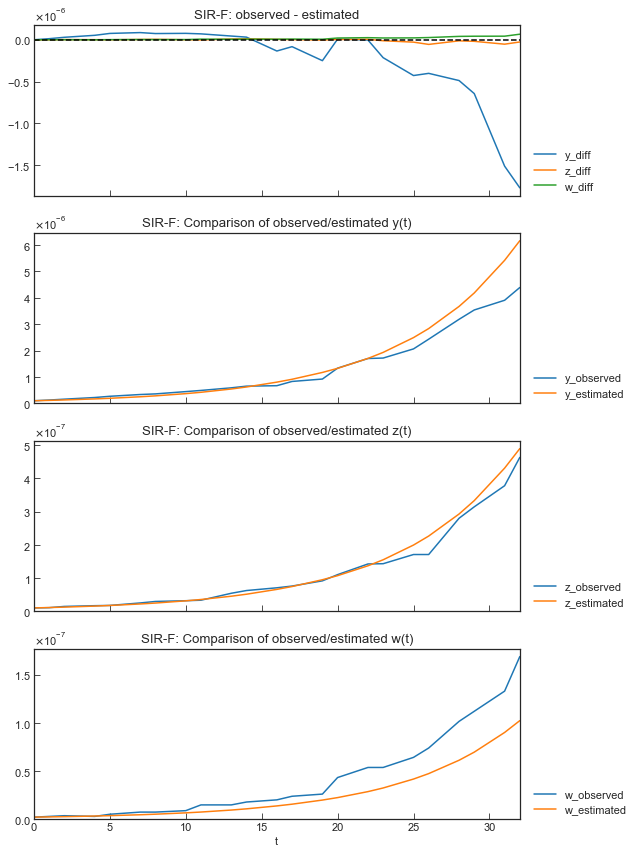

In [115]:
sirf_estimator.compare_graph()

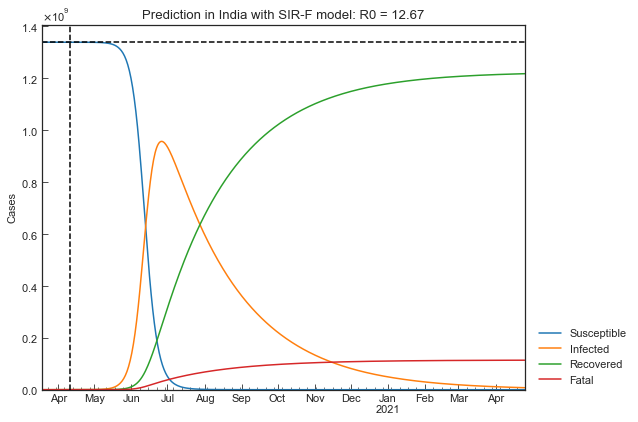

In [116]:
sirf_estimator.predict_graph(step_n=600)

In [117]:
df = sirf_estimator.predict_df(300)
df.loc[datetime.today():, ["Infected", "Recovered", "Fatal"]].head(14).style.background_gradient(axis=0)

,Infected,Recovered,Fatal
Time,,,
2020-04-11 04:48:00,8755,695,145
2020-04-11 20:56:00,9548,758,158
2020-04-12 13:04:00,10566,838,175
2020-04-13 05:12:00,11849,940,196
2020-04-13 21:20:00,13445,1066,222
2020-04-14 13:28:00,15400,1220,255
2020-04-15 05:36:00,17767,1408,294
2020-04-15 21:44:00,20599,1631,341
2020-04-16 13:52:00,23954,1897,396


# SIR-F with exposed/waiting cases
The number of exposed cases in latent period (E) and wating cases for confirmation (W) are un-measurable variables, but key variables as well as S, I, R, F. If E and W are large, outbreak will occur in the near future. Let's replace S $\overset{\beta \mathrm{I}}{\longrightarrow}$ S$^\ast$ with S $\overset{\beta_1 \mathrm{(W+I)}}{\longrightarrow}$ E $\overset{\beta_2}{\longrightarrow}$ W $\overset{\beta_3}{\longrightarrow}$ S$^\ast$ because W also has infectivity.

Note:  
W and some rules were added to explain COVID-19 dataset, but this is like-SEIR model.  
To study general SEIR-model, please refer to PDF material in [Introduction to SEIR model Models](http://indico.ictp.it/event/7960/session/3/contribution/19/material/slides/).

## What is SEWIR-F model?
* S: Susceptible
* <u>E: Exposed and in latent period (without infectivity)</u>
* <u>W: Waiting cases for confirmation (with infectivity)</u>
* S$^\ast$: Confirmed and un-categorized
* I: Confirmed and categorized as I
* R: Recovered
* F: Fatal with confirmation

Measurable variables:  
Total population - Confirmed = $S+E+W+S^\ast$  
Confirmed = $I+R+F$  
Recovered = $R$  
Deaths = $F$  

Model:  
S $\overset{\beta_1 \mathrm{(W+I)}}{\longrightarrow}$ E $\overset{\beta_2}{\longrightarrow}$ W $\overset{\beta_3}{\longrightarrow}$ S$^\ast$ $\overset{\alpha_1}{\longrightarrow}$ F  
S $\overset{\beta_1 \mathrm{(W+I)}}{\longrightarrow}$ E $\overset{\beta_2}{\longrightarrow}$ W $\overset{\beta_3}{\longrightarrow}$ S$^\ast$ $\overset{1 - \alpha_1}{\longrightarrow}$ I  
I $\overset{\gamma}{\longrightarrow}$ R  
I $\overset{\alpha_2}{\longrightarrow}$ F  

$\alpha_1$: Mortality rate of S$^\ast$ cases [-]  
$\alpha_2$: Mortality rate of I cases [1/min]  
$\beta_1$: <u>Exposure rate (the number of encounter with the virus in a minute)</u> [1/min]  
$\beta_2$: <u>Inverse of latent period</u> [1/min]  
$\beta_3$: <u>Inverse of waiting time for confirmation</u> [1/min]  
$\gamma$: Recovery rate [1/min]  

Ordinary Differential Equation (ODE):   
$\frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta_1 S (W + I)$  
$\frac{\mathrm{d}E}{\mathrm{d}T}= N^{-1}\beta_1 S (W + I) - \beta_2 E$  
$\frac{\mathrm{d}W}{\mathrm{d}T}= \beta_2 E - \beta_3 W$  
$\frac{\mathrm{d}I}{\mathrm{d}T}= (1 - \alpha_1)\beta_3 W - (\gamma + \alpha_2) I$  
$\frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I$  
$\frac{\mathrm{d}F}{\mathrm{d}T}= N^{-1}\alpha_1 \beta_3 W + \alpha_2 I$  

Where $N=S+E+W+I+R+F$ is the total population, $T$ is the elapsed time from the start date.

## Non-dimensional SEWIR-F model
Set $(S, E, W, I, R, F) = N \times (x_1, x_2, x_3, y, z, w)$, $(T, \alpha_1) = (\tau t, \theta)$ and $(\alpha_2, \beta_i, \gamma) = \tau^{-1} \times (\kappa, \rho_i, \sigma)$.  
This results in the ODE  
$\frac{\mathrm{d}x_1}{\mathrm{d}t}= - \rho_1 x_1 (x_3 + y)$  
$\frac{\mathrm{d}x_2}{\mathrm{d}t}= \rho_1 x_1 (x_3 + y) - \rho_2 x_2$  
$\frac{\mathrm{d}x_3}{\mathrm{d}t}= \rho_2 x_2 - \rho_3 x_3$  
$\frac{\mathrm{d}y}{\mathrm{d}t}= (1-\theta) \rho_3 x_3 - (\sigma + \kappa) y$  
$\frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y$  
$\frac{\mathrm{d}w}{\mathrm{d}t}= \theta \rho_3 x_3 + \kappa y$  

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
$0 < (x_i, y, z, w, \theta, \kappa, \rho_i, \sigma) < 1$  
$1 \leq \tau \leq 1440$  

Reproduction number can be defined as  
$R_0 = \rho_1 (1-\theta) (\sigma + \kappa)^{-1}$

## Calculate $\rho_2$ and $\rho_3$
To estimate $\rho_2 = \tau \beta_2$ and $\rho_3 = \tau \beta_3$, we first calculate median value of latent period $\overline{L_{E}}$ and waiting time for confirmation $\overline{L_{W}}$ using linelist. We assume that patients start to have infectivity from onset dates. This means latent period is equal to incubation period.

$\beta_2$: Inverse of latent period [1/min]  
$\beta_3$: Inverse of waiting time for confirmation [1/min]

In [118]:
period_df = select_area(linelist_df, group=None)
period_df = period_df.loc[:, ["Exposed_date", "Onset_date", "Confirmed_date"]]
period_df["Latent [min]"] = (period_df["Onset_date"] - period_df["Exposed_date"]).dt.total_seconds() / 60
period_df["Waiting [min]"] = (period_df["Confirmed_date"] - period_df["Onset_date"]).dt.total_seconds() / 60
period_df["Latent [day]"] = period_df["Latent [min]"] / 60 / 24
period_df["Waiting [day]"] = period_df["Waiting [min]"] / 60 / 24
period_df["Latent + Waiting [day]"] = period_df["Latent [day]"] + period_df["Waiting [day]"]
period_df.dropna(axis=0).tail()

,Exposed_date,Onset_date,Confirmed_date,Latent [min],Waiting [min],Latent [day],Waiting [day],Latent + Waiting [day]
948,2020-01-25,2020-02-24,2020-02-24,43200.0,0.0,30.0,0.0,30.0
949,2020-01-25,2020-02-04,2020-02-24,14400.0,28800.0,10.0,20.0,30.0
957,2020-01-25,2020-02-12,2020-02-26,25920.0,20160.0,18.0,14.0,32.0
958,2020-01-25,2020-02-17,2020-02-26,33120.0,12960.0,23.0,9.0,32.0
1084,2020-02-15,2020-02-17,2020-02-25,2880.0,11520.0,2.0,8.0,10.0


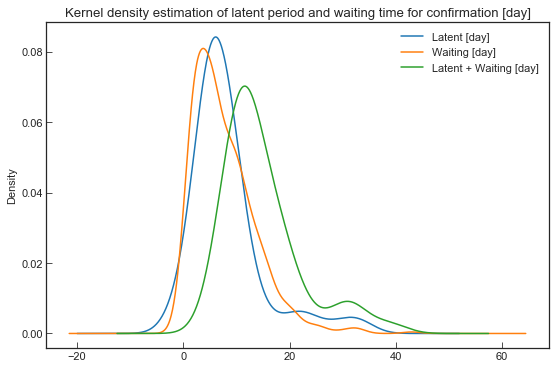

,count,mean,std,min,25%,50%,75%,max
Latent [day],83.0,8.180723,6.786185,-2.0,4.0,6.0,9.0,34.0
Waiting [day],563.0,7.682060,5.890473,0.0,3.0,6.0,11.0,43.0
Latent + Waiting [day],83.0,14.819277,7.305435,5.0,10.0,13.0,17.5,40.0


In [119]:
cols = ["Latent [day]", "Waiting [day]", "Latent + Waiting [day]"]
period_df[cols].plot.kde()
plt.title("Kernel density estimation of latent period and waiting time for confirmation [day]")
plt.show()
period_df[cols].describe().T

In [120]:
latent_period = period_df["Latent [min]"].median()
waiting_time = period_df["Waiting [min]"].median()
latent_waiting_day = period_df["Latent + Waiting [day]"].median()

In [121]:
tau = sirf_estimator.info()[1]["tau"]
rho2, rho3 = tau / latent_period, tau / waiting_time
(rho2, rho3)

(0.11203703703703702, 0.11203703703703702)

## Estimate $\rho_1$
We will estimate $\rho_1$ and the other parameters by hyperparameter estimation of SEWIR-F model.

In [122]:
%%time
sewirf_estimator = Estimator(
    SEWIRF, ncov_df, population_dict[critical_country],
    name=critical_country, excluded_places=[(critical_country, None)],
    start_date=critical_country_start,
    tau=tau, rho2=rho2, rho3=rho3
)
sewirf_dict = sewirf_estimator.run()

Wall time: 55.1 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:168: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



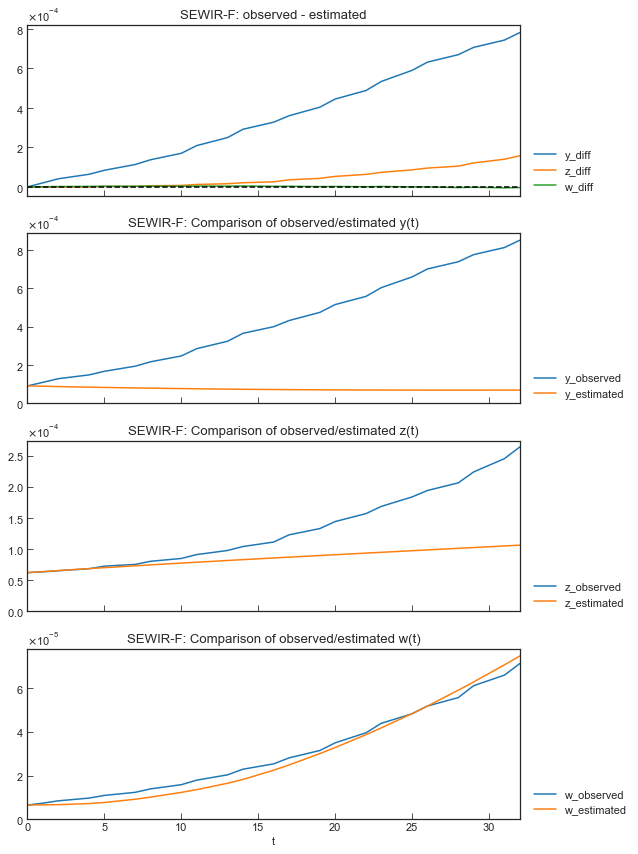

In [123]:
sewirf_estimator.compare_graph()

In [124]:
pd.DataFrame.from_dict({"SIR-F": sirf_dict, "SEWIR-F": sewirf_dict}, orient="index").fillna("-")

,tau,theta,kappa,rho,sigma,R0,score,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],rho1,rho2,rho3,1/beta1 [day],1/beta2 [day],1/beta3 [day]
SIR-F,968,0.009062,0.000844,0.140159,0.010117,12.67,0.471085,0.009,796,4,66,-,-,-,-,-,-
SEWIR-F,968,0.736505,0.000602,-,0.018207,0.86,1.777254,0.737,1116,-,36,0.061216,0.112037,0.112037,10,6,6


## Prediction with SEWIR-F model

In [125]:
first_model, info_dict, param_dict = sewirf_estimator.info()

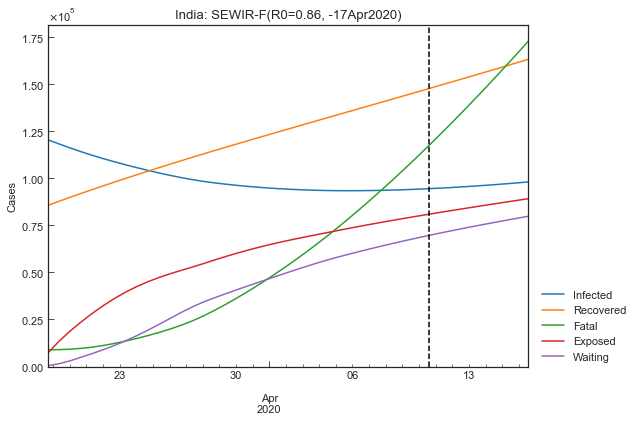

In [126]:
predicter = Predicter(**info_dict)
predicter.add(SEWIRF, end_day_n=None, vline=False, **param_dict)
predicter.add(SEWIRF, end_day_n=7, count_from_last=True, **param_dict)
predicter.restore_graph(drop_cols=["Susceptible"])

In [127]:
df = predicter.restore_df()
df.loc[datetime.today():, ["Exposed", "Waiting", "Infected", "Recovered", "Fatal"]].style.background_gradient(axis=0)

,Exposed,Waiting,Infected,Recovered,Fatal
Time,,,,,
2020-04-11 04:48:00,81736,70724,94681,149127,122589
2020-04-11 20:56:00,82694,71943,95003,150853,128533
2020-04-12 13:04:00,83639,73133,95355,152586,134576
2020-04-13 05:12:00,84573,74297,95734,154326,140716
2020-04-13 21:20:00,85497,75436,96140,156072,146952
2020-04-14 13:28:00,86413,76552,96571,157827,153281
2020-04-15 05:36:00,87321,77646,97026,159589,159701
2020-04-15 21:44:00,88223,78721,97505,161360,166211
2020-04-16 13:52:00,89119,79776,98006,163140,172809


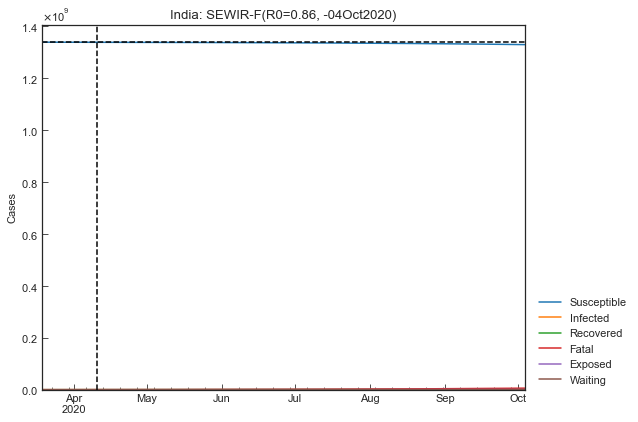

In [128]:
predicter = Predicter(**info_dict)
predicter.add(SEWIRF, end_day_n=200, count_from_last=False, **param_dict)
predicter.restore_graph(drop_cols=None)

# Factors of model parameters
To figure out what to do for minimizing the damage, we will perform scenario analysis in the next section. In this section, we will define the control factors of the SIR-F parameters.

## Control factors of effective contact rate $\beta_1$
Please reconsider S $\overset{\beta_1 \mathrm{(W+I)}}{\longrightarrow}$ E formula. Susceptible persons may contact with waiting/confirmed patients, and susceptible persons will be infected with COVID-19. The formura can be replaced with  
S$_\mathrm{q}$ $\overset{g_{s}}{\Longleftrightarrow}$ S$_{\mathrm{g}}$ $\overset{f_1}{\longrightarrow}$ E$^\ast$ $\overset{e^{-h_2}}{\longrightarrow}$ E  
W$_\mathrm{q}$ $\overset{g_w}{\Longleftrightarrow}$ W$_{\mathrm{g}}$  
I$_\mathrm{q}$ $\overset{g_i}{\Longleftrightarrow}$ I$_{\mathrm{g}}$  
I$_\mathrm{q}$ $\overset{q}{\longrightarrow}$ I$_{\hat{\mathrm{q}}}$  
E$^\ast$ $\overset{1-e^{-h_2}}{\longrightarrow}$ R$^\ast$

$\Longleftrightarrow$ (as substitute for $\longrightarrow$ with $\longleftarrow$) means that right side can be return to the left side.  
S$_\mathrm{q}$: Susceptible persons with self-quaranting <!--Susceptible in the strict sense-->  
S$_\mathrm{g}$: Susceptible persons with family members or friends etc.  
W$_\mathrm{q}$: Waiting patients with self-quaranting  
W$_\mathrm{g}$: Waiting patients with family members or friends etc.  
I$_\mathrm{q}$: Confimered and un-recovered patients with self-quaranting  
I$_\mathrm{g}$: Confimered and un-recovered patients with family members or friends etc.  
I$_\hat{\mathrm{q}}$: Confimered and un-recovered patients who was hospitalized  
E$^\ast$: Just after being exposed to the virus  
R$^\ast$: Being exposed to the virus, fighted with the virus, recovered and immuned without confirmation  

$f_1 = v(W_{\mathrm{g}} + I_{\mathrm{g}})(1-m)^2(1-w_e)^{w_n}e^{-h_1}sc$ [-] 

Control factors:  
$g_s$: The number of days in <u>a week</u> susceptible persons go out [day]  
$g_w$: The number of days in <u>a week</u> waiting but un-quarantined persons go out [day]  
$g_i$: The number of days in <u>a week</u> currently infected (confirmed) but un-quarantined persons go out [day]  
$q$: Quarantine rate of currently infected (confirmed) patients [-]  
$v$: Probability of virus existance in a droplet [-]  
$m$: Rate of persons wearing masks effectively (depends logistically on supply of masks) [-]  
$w_e$: Virus reduction effect of washing hands [-]  
$w_n$: The number of times people washes their hands before touching their own faces after go out [-]  
$h_1$: Health condition (active rate of cellular immunity factors) of susceptible and contacted persons [-]  
$h_2$: Health condition (active rate of humoral immunity factors) of susceptible and contacted persons [-]  
$c$: The number of contacts between susceptible persons and patients while on the go in a minute (depends on population density) [1/min]  
$\delta$:The product of unknown real factors [-]  

The parameter in the math model:  
$\beta_1 = \cfrac{1}{49}[g_s \{g_w + g_i (1-q) \} v (1-m)^2 (1-w_e)^{w_n} e^{-(h_{1}+h_{2})} c \delta]$ [1/min]

In [129]:
# Value of beta before actions are taken
beta1_before = param_dict["rho1"] / info_dict["tau"]
beta1_before

6.323966248370487e-05

### $g_s$ value before actions are taken
$g_s$: The number of days in <u>a week</u>, susceptible persons go out [day]  

We can calculate weighted average of days with age composion of population.

In [130]:
ec_out_df = go_out(critical_country)
ec_out_df

,Age_first,Age_last,Period_of_life,School,Office,Others,Portion
0,0,2,nursery,3,0,0,0.051289
1,3,5,nursery school,4,0,1,0.051752
2,6,10,elementary school,5,0,1,0.088830
3,11,13,middle school,5,0,1,0.055770
4,14,18,high school,6,0,1,0.092191
5,19,25,university/work,3,3,1,0.124634
6,26,35,work,0,6,1,0.164456
7,36,45,work,0,5,1,0.135250
8,46,55,work,0,5,1,0.103354
9,56,65,work,0,5,1,0.074217


In [131]:
gs_before = (ec_out_df[["School", "Office", "Others"]].sum(axis=1) * ec_out_df["Portion"]).sum()
gs_before

6.038351520765703

### $g_s$ value AFTER actions are taken
If all schools and offices will be closed, $g_s$ can be reduced. People will go out one day for other reasons instead of going to school/office.

In [132]:
df = ec_out_df.copy()
df["School"] = 0
df["Office"] = 0
df.loc[df.index[1:9], "Others"] += 1
gs_after = (df[["School", "Office", "Others"]].sum(axis=1) * df["Portion"]).sum()
gs_after

1.9189283262651937

## Impact of actions on $\beta_1$
Actions to take since today:  
All schools and offices will be closed.  

In [133]:
beta1_after = beta1_before * (gs_after / gs_before)
beta1_after / beta1_before

0.31779009878210285

## Predict the future: with actions since today
There is a delay between the time point of starting actions and that of appearing the effect. Because I is the main variable, the length of delay can be estimated as sum of latent period and waiting time for confirmation. This value [day] was calculated in "The number of exposed cases and waiting cases" section.

In [134]:
latent_waiting_day

13.0

In [135]:
first_model, info_dict, param_dict = sewirf_estimator.info()
info_dict["name"] = critical_country
changed_param_dict = param_dict.copy()
changed_param_dict["rho1"] = param_dict["rho1"] * beta1_after / beta1_before
df = pd.DataFrame.from_dict(
    {"No actions": param_dict, "With actions": changed_param_dict},
    orient="index"
)
df = df.loc[:, ["rho1", "rho2", "rho3", "theta", "kappa", "sigma"]]
df["R0"] = df.apply(lambda x: first_model(**x.to_dict()).calc_r0(), axis=1)
df["tau"] = info_dict["tau"]
df

,rho1,rho2,rho3,theta,kappa,sigma,R0,tau
No actions,0.061216,0.112037,0.112037,0.736505,0.000602,0.018207,0.86,968
With actions,0.019454,0.112037,0.112037,0.736505,0.000602,0.018207,0.27,968


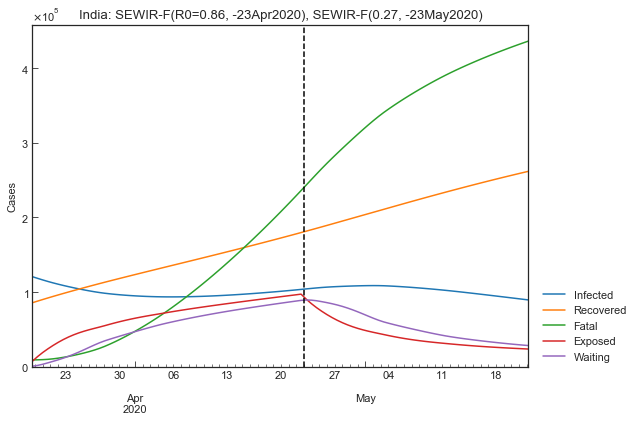

In [136]:
predicter = Predicter(**info_dict)
predicter.add(SEWIRF, end_day_n=None, count_from_last=False, vline=False, **param_dict)
predicter.add(SEWIRF, end_day_n=latent_waiting_day, count_from_last=True, **param_dict)
predicter.add(SEWIRF, end_day_n=30, count_from_last=True, **changed_param_dict)
predicter.restore_graph(drop_cols=["Susceptible"])

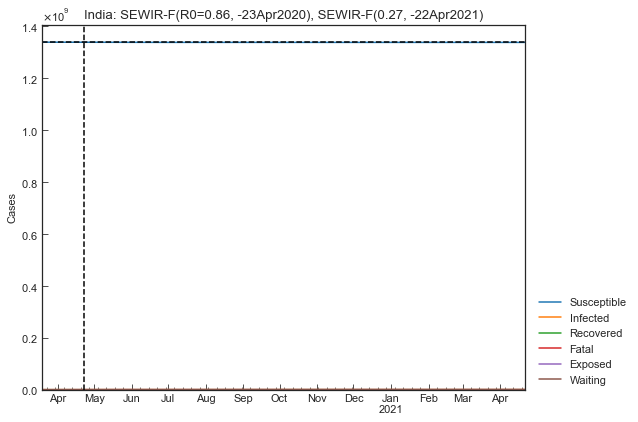

In [137]:
predicter = Predicter(**info_dict)
predicter.add(SEWIRF, end_day_n=None, count_from_last=False, vline=False, **param_dict)
predicter.add(SEWIRF, end_day_n=latent_waiting_day, count_from_last=True, **param_dict)
predicter.add(SEWIRF, end_day_n=400, count_from_last=False, **changed_param_dict)
predicter.restore_graph(drop_cols=None)

The actions result in:  
Total number of confirmed cases was decreased.  
Peak point of infected cases was delayed.   
We need to fight with the virus for longer period.

## Control factors of recovery rate $\gamma$ and mortality rate $\alpha_2$
Here, let's reconsider I $\overset{\gamma}{\longrightarrow}$ R and I $\overset{\alpha_2}{\longrightarrow}$ F.  
Because balance of immunity (+effect of treatments) and virulence determines whether patients can recover or not, the formulas can be replaced with  

I $\overset{\bar{h}}{\longrightarrow}$ I$^\star$ $\overset{\bar{s}}{\longrightarrow}$ F$^\star$ $\overset{L^{-1}}{\longrightarrow}$ F  
I $\overset{f_2}{\longrightarrow}$ R$^\star$ $\overset{l^{-1}}{\longrightarrow}$ R  

I$^\star$: Confirmed cases whose immune systems did not overcome virus multiplication, and <u>without</u> severe events  
F$^\star$: Confirmed cases whose immune systems did not overcome virus multiplication, and <u>with</u> severe events  
R$^\star$: Confirmed cases whose immune systems overcame virus multiplication or comfirmed cases whose severe events can be stopped

Where $f_2 = 1 - \bar{h}\ \bar{s}$  

$\bar{h}$: Rate of I whose immune systems does NOT overcame virus multiplication [-]  
$\bar{s}$: Rate of I$^\star$ who have severe events, including respiratory failure  [-]  
$L_i$: Inverse of F$^\star$'s mortality rate for people $i$ years old [min]  
$l_i$: Inverse of R$^\star$'s mortality rate for people $i$ years old [min]  
$P_i$: The number of people $i$ years old [-]  
$N$: Total population  

\begin{align*}
& \alpha_2 = \cfrac{\bar{h}\ \bar{s}}{N} \sum_{n=0}^{\infty}\cfrac{P_{i}}{L_i} \\
    & \gamma = \cfrac{1 - \bar{h}\ \bar{s}}{N} \sum_{n=0}^{\infty}\cfrac{P_{i}}{l_i} \\
\end{align*}

## $\bar{h}$ and $\bar{s}$ value before actions are taken
We assume that $\bar{h}=0.5$ and $\bar{s}=0.5$. **(Yes, we need remove this assumtions later!)**  
**(Using population distribution data and case reports, $\bar{h}\ \bar{s}$ and $1 - \bar{h}\ \bar{s}$ can be calculated.)**

In [138]:
gamma_before = param_dict["sigma"] / info_dict["tau"]
alpha2_before = param_dict["kappa"] / info_dict["tau"]
(gamma_before, alpha2_before)

(1.880881385691768e-05, 6.218734369582677e-07)

In [139]:
h_bar_before, s_bar_before = 0.5, 0.5

## $\bar{h}$ and $\bar{s}$ value AFTER actions are taken
Assumtions of new medicines:  
"Protease inhibitor" inhibits virus multiplication. This will reduce $\bar{h}$

In [140]:
h_bar_after = 0.25
s_bar_after = s_bar_before

## Impact on $\gamma$ and $\alpha_2$
Actions to take:  
New Protein inhibitor medicine was introduced.

In [141]:
gamma_after = gamma_before * (1 - h_bar_after * s_bar_after) / (1 - h_bar_before * s_bar_before)
gamma_after

2.1943616166403957e-05

In [142]:
alpha2_after = alpha2_before * (h_bar_after * s_bar_after) / (h_bar_before * s_bar_before)
alpha2_after

3.1093671847913383e-07

## Predict the future: with actions from the next month

In [143]:
first_model, info_dict, param_dict = sewirf_estimator.info()
info_dict["name"] = critical_country
changed_param_dict = param_dict.copy()
changed_param_dict["sigma"] = param_dict["sigma"] * gamma_after / gamma_before
changed_param_dict["kappa"] = param_dict["kappa"] * alpha2_after / alpha2_before
df = pd.DataFrame.from_dict(
    {"No actions": param_dict, "With actions": changed_param_dict},
    orient="index"
)
df = df.loc[:, ["rho1", "rho2", "rho3", "theta", "kappa", "sigma"]]
df["R0"] = df.apply(lambda x: first_model(**x.to_dict()).calc_r0(), axis=1)
df["tau"] = info_dict["tau"]
df

,rho1,rho2,rho3,theta,kappa,sigma,R0,tau
No actions,0.061216,0.112037,0.112037,0.736505,0.000602,0.018207,0.86,968
With actions,0.061216,0.112037,0.112037,0.736505,0.000301,0.021241,0.75,968


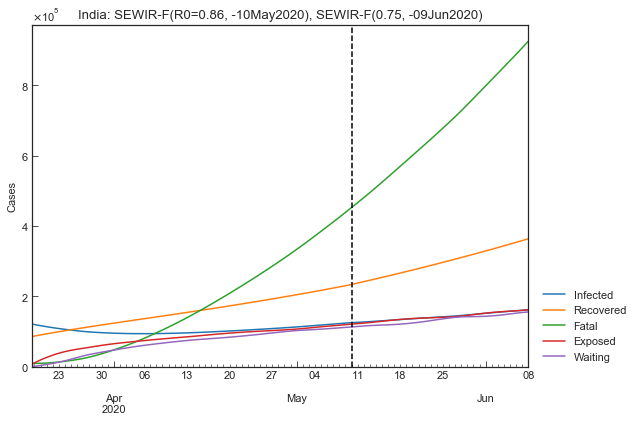

In [144]:
predicter = Predicter(**info_dict)
predicter.add(SEWIRF, end_day_n=None, count_from_last=False, vline=False, **param_dict)
predicter.add(SEWIRF, end_day_n=30, count_from_last=True, **param_dict)
predicter.add(SEWIRF, end_day_n=30, count_from_last=True, **changed_param_dict)
predicter.restore_graph(drop_cols=["Susceptible"])

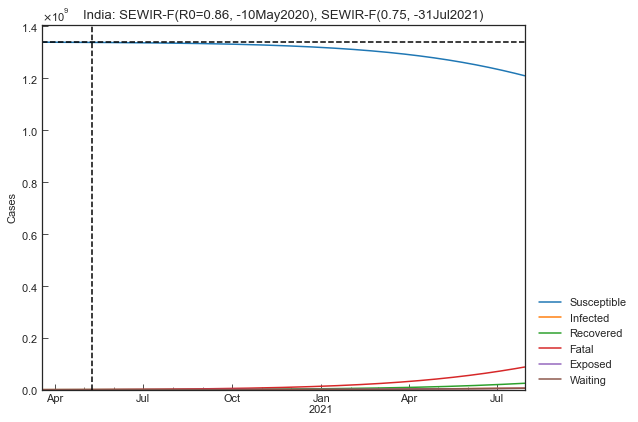

In [145]:
predicter = Predicter(**info_dict)
predicter.add(SEWIRF, end_day_n=None, count_from_last=False, vline=False, **param_dict)
predicter.add(SEWIRF, end_day_n=30, count_from_last=True, **param_dict)
predicter.add(SEWIRF, end_day_n=500, count_from_last=False, **changed_param_dict)
predicter.restore_graph(drop_cols=None)

The actions result in:  
Total numbers of confirmed/deaths cases were decreased.

## If 100,000/day are vaccinated (SIR-FV model) since today
We will predict the numbers of cases in the assumption that 100,000 persons will be vacctinated in one day until there are susceptible people.  
$\frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y - \omega$  
$\frac{\mathrm{d}y}{\mathrm{d}t}= \rho (1-\theta) x y - (\sigma + \kappa) y$  
$\frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y$  
$\frac{\mathrm{d}w}{\mathrm{d}t}= \rho \theta x y + \kappa y$  
Where $\omega_{(x>0)}=\frac{10,000,000}{N}$ and $N$ is the total population.

Reproduction number can be defined as  
$R_0 = \rho (1 - \theta) (\sigma + \kappa)^{-1}$

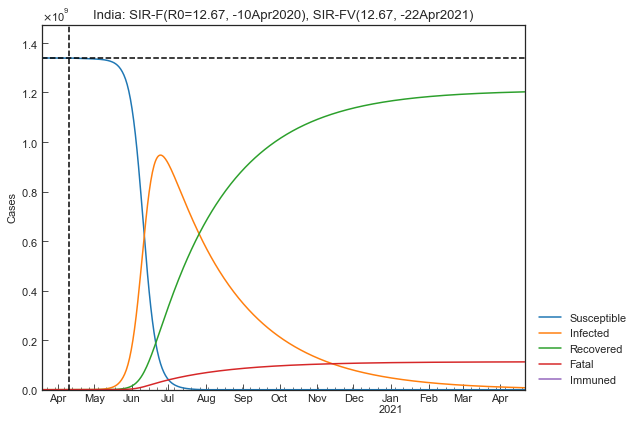

In [146]:
first_model, info_dict, param_dict = sirf_estimator.info()
changed_param_dict = param_dict.copy()
changed_param_dict["n"] = population_dict[critical_country]
changed_param_dict["v_per_day"] = 100000
predicter = Predicter(**info_dict)
predicter.add(SIRF, end_day_n=None, count_from_last=False, **param_dict)
predicter.add(SIRFV, end_day_n=400, count_from_last=False, **changed_param_dict)
predicter.restore_graph(drop_cols=None)

# Scenario in Italy
In this section, we will perform scenario analysis using the records of Italy.

In [147]:
ita_scenario = Scenario(ncov_df, name="Italy", places=[("Italy", None)])

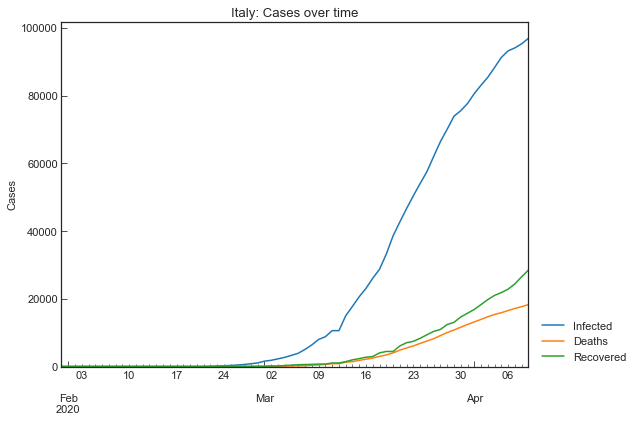

,Date,Confirmed,Infected,Deaths,Recovered
65,2020-04-05,128948,91246,15887,21815
66,2020-04-06,132547,93187,16523,22837
67,2020-04-07,135586,94067,17127,24392
68,2020-04-08,139422,95262,17669,26491
69,2020-04-09,143626,96877,18279,28470


In [148]:
ita_scenario.show_record().tail()

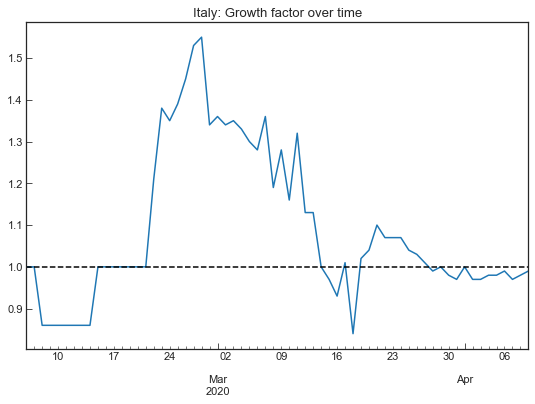

,Group,GF > 1 [straight days],GF < 1 [straight days]
Italy,Stopping,0,8


In [149]:
ita_scenario.growth_factor()

## Trend analysis

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


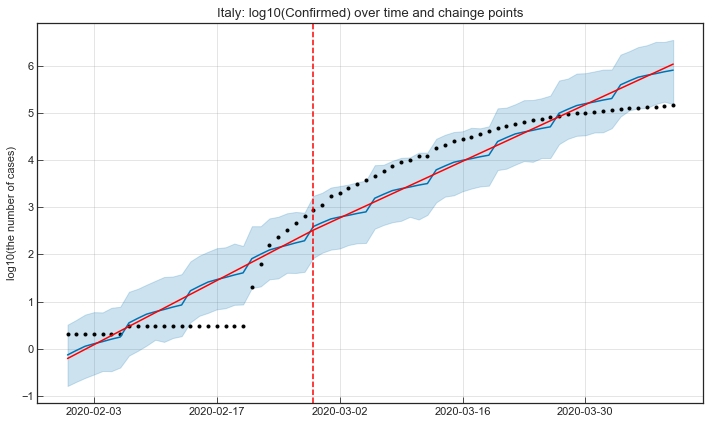

In [150]:
ita_scenario.trend(variables=["Confirmed"])

**We will use the records from 23Feb2020.**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


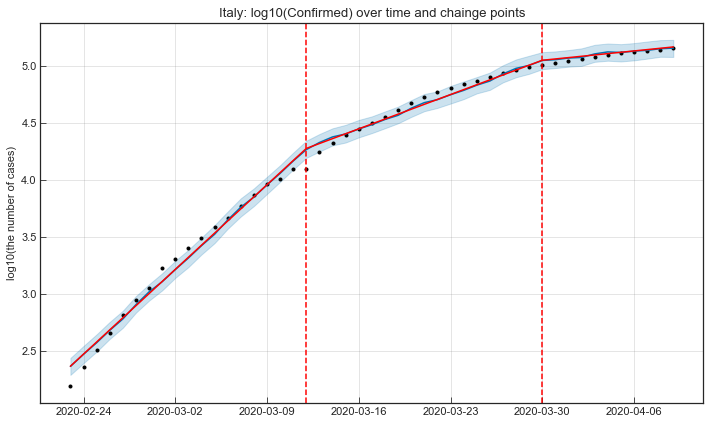

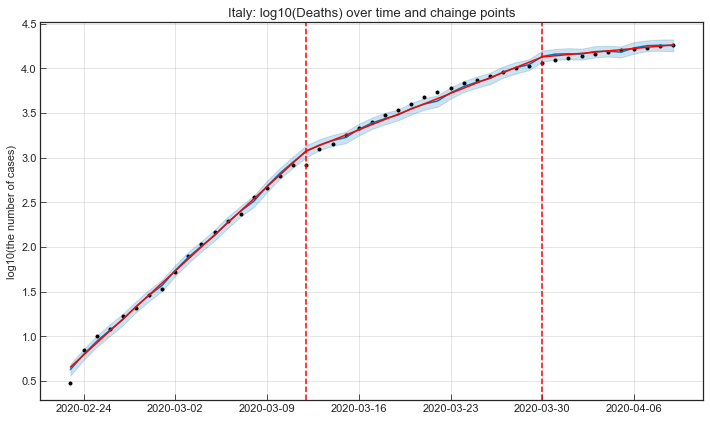

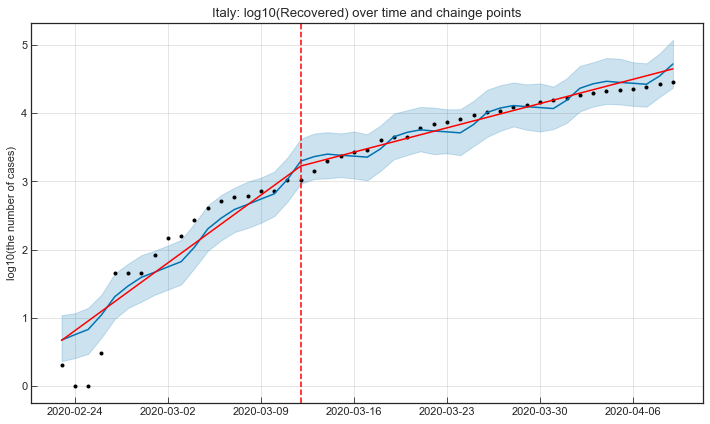

In [151]:
ita_scenario.trend(start_date="23Feb2020")

**There are three phases in Italy.**
* From 23Feb2020 to 10Mar2020
* From 11Mar2020 to 27Mar2020
* From 28Mar2020 to today

In [152]:
ita_scenario.set_phase(
    start_dates=["23Feb2020", "11Mar2020", "28Mar2020"],
    population=population_dict["Italy"]
)

,start_date,end_date,population
1st,23Feb2020,10Mar2020,60480000
2nd,11Mar2020,27Mar2020,60480000
3rd,28Mar2020,-,60480000


## Estimate SIR-F parameters

In [153]:
ita_scenario.estimate(SIRF)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 10 sec.
		100 trials finished in 0 min 11 sec.
		100 trials finished in 0 min 11 sec.
		100 trials finished in 0 min 12 sec.
		100 trials finished in 0 min 13 sec.
		100 trials finished in 0 min 14 sec.
		100 trials finished in 0 min 16 sec.
		100 trials finished in 0 min 17 sec.
		100 trials finished in 0 min 18 sec.
		100 trials finished in 0 min 19 sec.
		100 trials finished in 0 min 21 sec.
		100 trials finished in 0 min 22 sec.


IndexError: list index out of range

### 1st phase

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:168: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



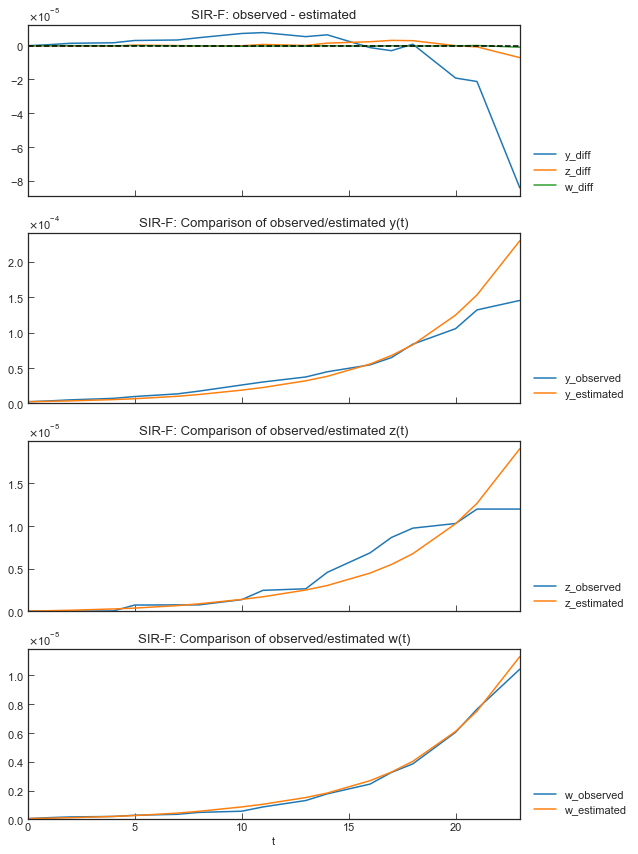

In [154]:
ita_scenario.accuracy_graph(phase_n=1)

### 2nd phase
$\tau$ of 2nd phase is the same as that of 1st phase.

In [155]:
ita_scenario.accuracy_graph(phase_n=2)

KeyError: 'phase_n must be in 1st - 1st'

### 3rd phase
$\tau$ of 3rd phase is the same as that of 1st phase.

In [ ]:
ita_scenario.accuracy_graph(phase_n=3)

### Compare predicted number of confirmed cases

In [ ]:
ita_scenario.compare_estimated_numbers()

### Compare parameters

In [ ]:
ita_scenario.param_df

In [ ]:
ita_scenario.param_history(["rho", "sigma"])

**Non-dimensional effective contact rate $\rho$ seems to be reduced.**

## Why $\rho$ was reduced?

In [ ]:
ita_scenario.param_df[["start_date", "end_date", "rho"]]

In [ ]:
def _color(data_df):
    df = data_df.copy()
    df.loc[:, :] = str()
    df.iloc[[3, 6, 8], :] = "background-color: lightgreen"
    return df

ita_action_df.style.apply(_color, axis=None)

**It seems that (quaranitine of person contacted with positive patients), school closure and lockdown reduced $\rho$ value.**

## Effect of school closure/lockdown

Acording to first report of [COVID-19 Mobility Monitoring project](https://covid19mm.github.io/in-progress/2020/03/13/first-report-assessment.html) on 13Mar2020, the government of Italy declared a national lockdown on 09Mar2020 and all peole are asked to remain home. This resulted in average reduction of potential encounters of 19% during week 3 (from 07Mar2020 to 10Mar2020).

**Here, we will predict the effect of school closure (started before 04Mar2020), lockdown on 13Mar2020 with assumtion that the effect will be shown from the start date of 3rd phase.**

### Real factors of $\beta_1$

The parameter in the math model:  
$\rho_1 = \tau \beta_1$  
$\beta_1 = \cfrac{1}{49}[g_s \{g_w + g_i (1-q) \} v (1-m)^2 (1-w_e)^{w_n} e^{-(h_{1}+h_{2})} c \delta]$ [1/min]

Control factors:  
$g_s$: The number of days in <u>a week</u> susceptible persons go out [day]  
$g_w$: The number of days in <u>a week</u> waiting but un-quarantined persons go out [day]  
$g_i$: The number of days in <u>a week</u> currently infected (confirmed) but un-quarantined persons go out [day]  
$q$: Quarantine rate of currently infected (confirmed) patients [-]  
$v$: Probability of virus existance in a droplet [-]  
$m$: Rate of persons wearing masks effectively (depends logistically on supply of masks) [-]  
$w_e$: Virus reduction effect of washing hands [-]  
$w_n$: The number of times people washes their hands before touching their own faces after go out [-]  
$h_1$: Health condition (active rate of cellular immunity factors) of susceptible and contacted persons [-]  
$h_2$: Health condition (active rate of humoral immunity factors) of susceptible and contacted persons [-]  
$c$: The number of contacts between susceptible persons and patients while on the go in a minute (depends on population density) [1/min]  
$\delta$:The product of unknown real factors [-]  

### Value of control factors of $\beta_1$ before/after the national lockdown
A national lockdown will effect on $g_s$ and $c$.

Acccoring the report, we assume average reduction of potential encounters of 19%.

In [ ]:
c_before, c_after = 1.0, 0.81

### $g_s$ before the lockdown
We will estimate average number peple go out using @marcoferrante estimation table and population pyramid data.
It is necessary to replace the population pyramid data for Italy because the situation is different from the average data.

In [ ]:
ita_out_df = go_out("Italy")
ita_out_df

In [ ]:
gs_before = (ita_out_df[["School", "Office", "Others"]].sum(axis=1) * ita_out_df["Portion"]).sum()
gs_before

### Estimation of $g_s$ after school closure/lockdown
Here, we estimate the $g_s$ after school closure/lockdown with the assumption that only $g_s$ and $c$ was changed.   

Because
$$\cfrac{\rho_{\mathrm{after}}}{gs_{\mathrm{after}}\times c_{\mathrm{after}}} = \cfrac{\rho_{\mathrm{before}}}{gs_{\mathrm{before}}\times c_{\mathrm{before}}}$$

$gs_{\mathrm{after}}$ is

In [ ]:
rho_before = ita_scenario.param("1st", "rho")
rho_after = ita_scenario.param("3rd", "rho")
gs_after = rho_after / rho_before / c_after * gs_before * c_before
print(f"{round(gs_after, 1)} days in a week susceptible people go out.")

Let's apply this value to the go_out table!  
We assume that workers go to their office one day in a week.

In [ ]:
df = ita_out_df.copy()
df["School"] = 0
df.loc[df["Office"] > 0, "Office"] = 1
sum_so = (df[["School", "Office"]].sum(axis=1) * df["Portion"]).sum()
df.loc[df["Others"] > 0, "Others"] = round(gs_after - sum_so, 1)
ita_out_after_df = df.copy()
ita_out_after_df

Check the $g_s$ value calculated with the table.

In [ ]:
gs_after = (ita_out_after_df[["School", "Office", "Others"]].sum(axis=1) * ita_out_after_df["Portion"]).sum()
round(gs_after, 1)

## Predict the future with 3rd parameters

In a week,

In [ ]:
ita_scenario.predict(days=7).tail(7).style.background_gradient(axis=0)

In 30 days,

In [ ]:
ita_scenario.predict(days=30).tail(7).style.background_gradient(axis=0)

In the long-term,

In [ ]:
_ = ita_scenario.predict(days=1000, min_infected=1)

## Effect of expected new medicines (Favipiravir, AVIGAN)
New medicines are necessary so that patients can recover more quicky from the disease. Drug repositioning strategy (i.e.finding effective candidates from library of existing drugs of different diseases) is used to develop the medicines of COVID-19. For example, Favipiravir (AVIGAN) is a candidate. Certainly, this medicine may lead many serious adverse reactions and it cannot be provided to expectant mothers [KEGG database AVIGAN](https://www.kegg.jp/medicus-bin/japic_med?japic_code=00066852) (Sorry, this is written in Japanese). However, it may help to save many thousand lives.  

**We do not have information about its criteria to administrate and medicinal effect on COVID-19. We assume that fatal risk $\bar{h}\ \bar{s}$ will be halved (0.50 $\to$ 0.25) from 01May2020.**
(The values may be different for each age group, but we assume they are constant now.)

Where  
\begin{align*}
& \kappa \tau^{-1} = \alpha_2 = \cfrac{\bar{h}\ \bar{s}}{N} \sum_{n=0}^{\infty}\cfrac{P_{i}}{L_i} \\
& \sigma \tau^{-1} = \gamma = \cfrac{1 - \bar{h}\ \bar{s}}{N} \sum_{n=0}^{\infty}\cfrac{P_{i}}{l_i} \\
\end{align*}

$\bar{h}$: Rate of I whose immune systems does NOT overcame virus multiplication [-]  
$\bar{s}$: Rate of I$^\star$ who have severe events, including respiratory failure  [-]  
$L_i$: Inverse of F$^\star$'s mortality rate for people $i$ years old [min]  
$l_i$: Inverse of R$^\star$'s mortality rate for people $i$ years old [min]  
$P_i$: The number of people $i$ years old [-]  
$N$: Total population  



In [ ]:
med_kappa = ita_scenario.param("3rd", "kappa") * 0.25 / 0.50
med_sigma = ita_scenario.param("3rd", "sigma") * (1 - 0.25) / (1 - 0.50)
ita_scenario.add_future_param(start_date="01May2020", kappa=med_kappa, sigma=med_sigma)

In three 90 days,

In [ ]:
df = ita_scenario.predict(days=90)

Values are here,

In [ ]:
df.tail(7).style.background_gradient(axis=0)

In the long-term,

In [ ]:
_ = ita_scenario.predict(days=1000, min_infected=1)

# Scenario in Japan
In this section, we will perform scenario analysis using the records of Japan.

In [ ]:
jpn_scenario = Scenario(ncov_df, name="Japan", places=[("Japan", None)])

In [ ]:
jpn_scenario.show_record().tail()

In [ ]:
jpn_scenario.growth_factor()

## Trend analysis

In [ ]:
jpn_scenario.trend(variables=["Confirmed"])

**We will use the records from 21Feb2020.**

In [ ]:
jpn_scenario.trend(start_date="21Feb2020", n_changepoints=2)

**There two phases in Japan.**
* From 10Mar2020 to 27Mar2020
* From 28Mar2020 to today

In [ ]:
jpn_scenario.set_phase(
    start_dates=["10Mar2020", "28Mar2020"],
    population=population_dict["Japan"]
)

## Estimate SIR-F parameters

In [ ]:
jpn_scenario.estimate(SIRF)

### 1st phase

In [ ]:
jpn_scenario.accuracy_graph(phase_n=1)

### 2nd phase

In [ ]:
jpn_scenario.accuracy_graph(phase_n=2)

### Compare predicted number of confirmed cases

In [ ]:
jpn_scenario.compare_estimated_numbers()

### Compare parameters

In [ ]:
jpn_scenario.param_df

In [ ]:
jpn_scenario.param_history(["kappa", "rho", "sigma"])

## Predict the future with 3rd parameters

In a week,

In [ ]:
jpn_scenario.predict(days=7).tail(7).style.background_gradient(axis=0)

In 30 days,

In [ ]:
jpn_scenario.predict(days=30).tail(7).style.background_gradient(axis=0)

In the logn-term,

In [ ]:
_ = jpn_scenario.predict(days=1000, min_infected=1)

## Strategy of Japan
Japan declared national emergency on 07Apr2020, but national lockdown will not be done. Japan is mainly taking the following three actions.
* Physical (social) distancing: to avoid closed space, crowd, conversation at close distance
* Trace the link of patients and give tests on the linked persons preferentially
* Maintain medical level to increase recovery rate and decrease mortality rate

## How to shift to stopping group by 31May2020

### The current situation
Under the assumtion that the current trend continues, when will Japan shift to stopping country?

In [ ]:
jpn_scenario.clear_future_param()
n = 0

while True:
    n += 1
    df = jpn_scenario.growth_factor(days_to_predict=n, show_figure=False)
    if df.iloc[0, 0] == "Stopping":
        break

jpn_scenario.growth_factor(days_to_predict=n)

### Max value of $\beta$ to meet the goal

### Max value of $g_s$ to meet the goal

## How to prevent overwhelming medical system
We need to flatten the curve of currently infected cases so that prevent overwhelming medical system. The peak value of currently infected cases must not exceed the number of hospital capacity.

### How many medical staffs, ICU beds, hospitals and other sites we have

### Severity of the currently infected patients
We categoize the patient with severity as the following.
* Grade1: Asymptomtic or mild symptoms, need self-quarantine at home or hotel
* Grade2: Severity is unknown and need hospitalization for diagnosis
* Grade3: Severe and need ICU

In [ ]:
# https://www.kaggle.com/lisphilar/covid19-dataset-in-japan
jpn_ncov_df.tail()

Proportion of each grade is as below.

In [ ]:
df = jpn_ncov_df.copy()
df["Grade1"] = df["Asymptomatic"] + df["Hosp_mild"]
df["Grade2"] = df["Sym-unknown"] + df["Hosp_unknown"] + df["Hosp_waiting"]
df["Grade3"] = df["Hosp_severe"]
df = df.loc[:, ["Grade1", "Grade2", "Grade3"]]
df = df.apply(lambda x: x / np.sum(x), axis=1)
grade_df = df.copy()
grade_df.tail()

In [ ]:
line_plot(grade_df, "Proportion of each grade over time")

In [ ]:
grade_df.plot.kde(title="Kernel density estiomation of protion of each grade")
plt.show()

In [ ]:
grade_df.describe().T

In [ ]:
grade_dict = grade_df.median().to_dict()
grade_dict

### Max value of $\gamma$ to meet the goal

### Are new medicines are effective?

# Remarks
Thank you for reading!  
Lisphilar from Japan

## Major update
 * 13Feb2020: SIR model
 * 15Feb2020: SIR-D model
 * 22Feb2020: SIR-F model
 * 23Feb2020: Changed the dataset from 2019_ncov_data.csv to covid_19_data.csv
 * 23Feb2020: $\tau$ was fixed as "1 day" because the time format of ObservationDate is MM/DD/YYYY
 * 23Feb2020: SIR-F model with other countries
 * 23Feb2020: How to minimize the damage (Change of parameter, Vacctination)
 * 24Feb2020: Use $\tau$ again
 * 01Mar2020: $\tau$ definition was changed. $1\leq \tau \mathrm{[hour]} \leq 24$ $\to$ $1\leq \tau \mathrm{[min]} \leq 1440$ 
 * 01Mar2020: Added "Test of hyperparameter optimization using example data" in SIR model section
 * 02Mar2020: Analysis of Linelist (estimation of Effective contact/Recovery/Death rate using case reports)
 * 03Mar2020: Trend analysis
 * 03Mar2020: Update estimator error function; Exponential Weighted Moving Average (span=14days) of |observed - estimated|
 * 04Mar2020: "Analysis of Linelist" was moved to [EDA of linelist](https://www.kaggle.com/lisphilar/eda-of-linelist?scriptVersionId=29640733#Remarks)
 * 04Mar2020: Data in Hubei and China will be analysed in another notebook. Please refer to [Data in China with SIR model](https://www.kaggle.com/lisphilar/data-in-china-with-sir-model?scriptVersionId=29646940).
 * 06Mar2020: Random seed was fixed as 2019
 * 06Mar2020: Update estimator error function; Weighted Average of |Exponential Weighted Moving Average (span=14days) of observed - estimated|
 * 07Mar2020: Update estimator error function; Total population $\times$ Wighted Average of |observed - estimated| with step number t
 * 07Mar2020: Priorities of variables in estimator error function was set as $(x, y, z, w) = (1, 10, 10, 1)$ in SIR-F model.
 * 09Mar2020: Update estimator error function; $(\mathrm{Population})^2$ $\times$ (Wighted Average of |observed - estimated|/[observed $\times$ Population + 1] with step number t)
 * 09Mar2020: Priorities of variables in estimator error function were set as $(x, y, z, w) = (1, 10, 10, 2)$ in SIR-F model.
 * 11Mar2020: Update model.param_dict(); each parametor range was limited to 30%-70% quantiles of the estimated values ($\frac{\mathrm{d}z}{\mathrm{d}t}\left(\frac{1}{y}\right)$ for $\sigma$) of training dataset.
 * 12Mar2020: Update model.param_dict(); each parameter range was limited to 5%-95% quantiles
 * 12Mar2020: Detailed scenario analysis. Thank you, Marco Ferrante!
 * 13Mar2020: Update model.param_dict(); each parameter range was limited to 0%-100% quantiles
 * 13Mar2020: Update "Detailed scenario analysis" > "Real factors of effective contact rate $\beta$"
 * 14Mar2020: Update model.param_dict(); rho/sigma range was limited to 30%-70% quantiles of their estimated values
 * 14Mar2020: Applied trend analysis on country level data to use only a part of records for estimation
 * 14Mar2020: Recovered without confirmation was added to "Real factors of effective contact rate $\beta$"
 * 15Mar2020: Merge "How to minimize the damage (Change of parameter, Vacctination)" with "Scenario analysis" section
 * 15Mar2020: Update Estimator, int to np.int. Thank you Enrico Papalini!
 * 15Mar2020: Update Estimator, some parameters can be fixed. Some of SIR parameters can be applied to SIR-F model.
 * 17Mar2020: The number of exposed cases and waiting cases
 * 17Mar2020: Update Scenario analysis
 * 18Mar2020: Scenario analysis in Italy
 * 19Mar2020: Estimation of new drugs effect in "Scenario analysis in Italy" section

## Remarks

With the models, we predicted the effect of actions on the numbers of cases. New medicines and vaccines are expected, but, in initial state, we must make an effort to minimize effective contact rate $\rho$ by quarantining/wearing of masks. This effort will reduce the number of infected cases directory.

## To-do list

* Find out the root cause of unstable accuracy of estimation and improve Estimater class
* Increase speed of the functions and classes. Estimater.run(), which uses Optuna and scipy.integrate.solve_ivp, is a key method, but time-consuming one.
* Reconsider the ODEs of SIR-F model using new records
* Find out the change points using case reports and news information, and feed-back to the model.
* Discuss $R_0$ using the data of the other infectious diseases
* Calculate the impact of preventive actions on the parameters of math models and find out effective preventive actions.